In [57]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM, GlobalAveragePooling1D, MultiHeadAttention
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tensorflow as tf
import shap
import pandas as pd

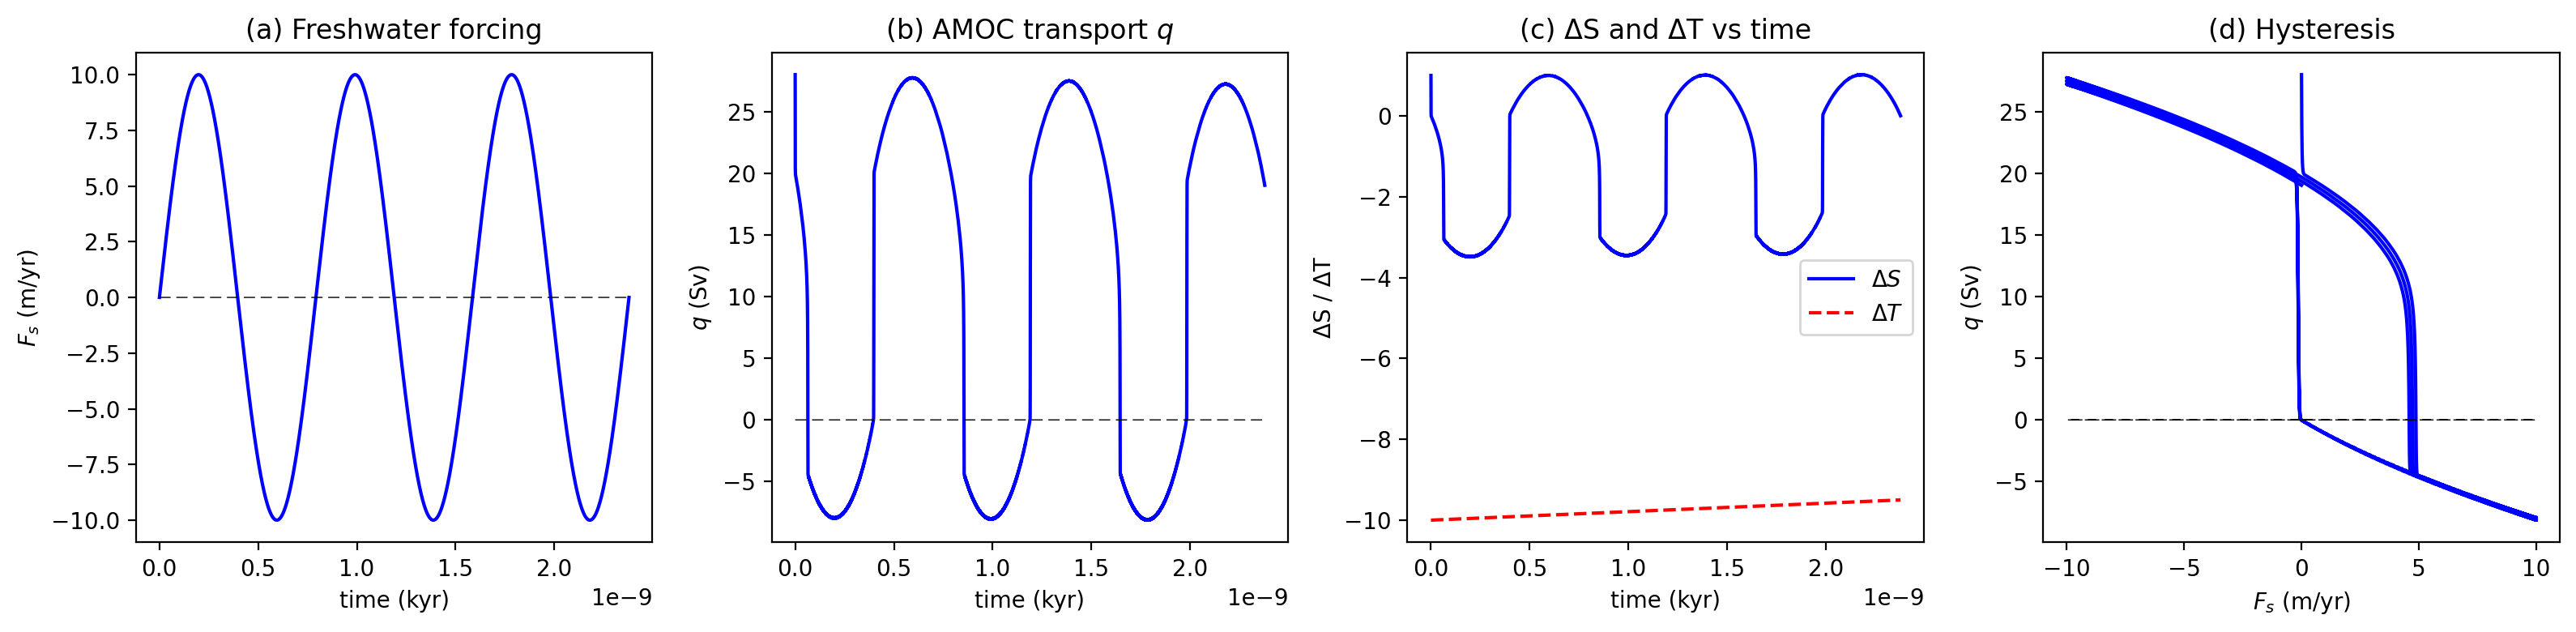

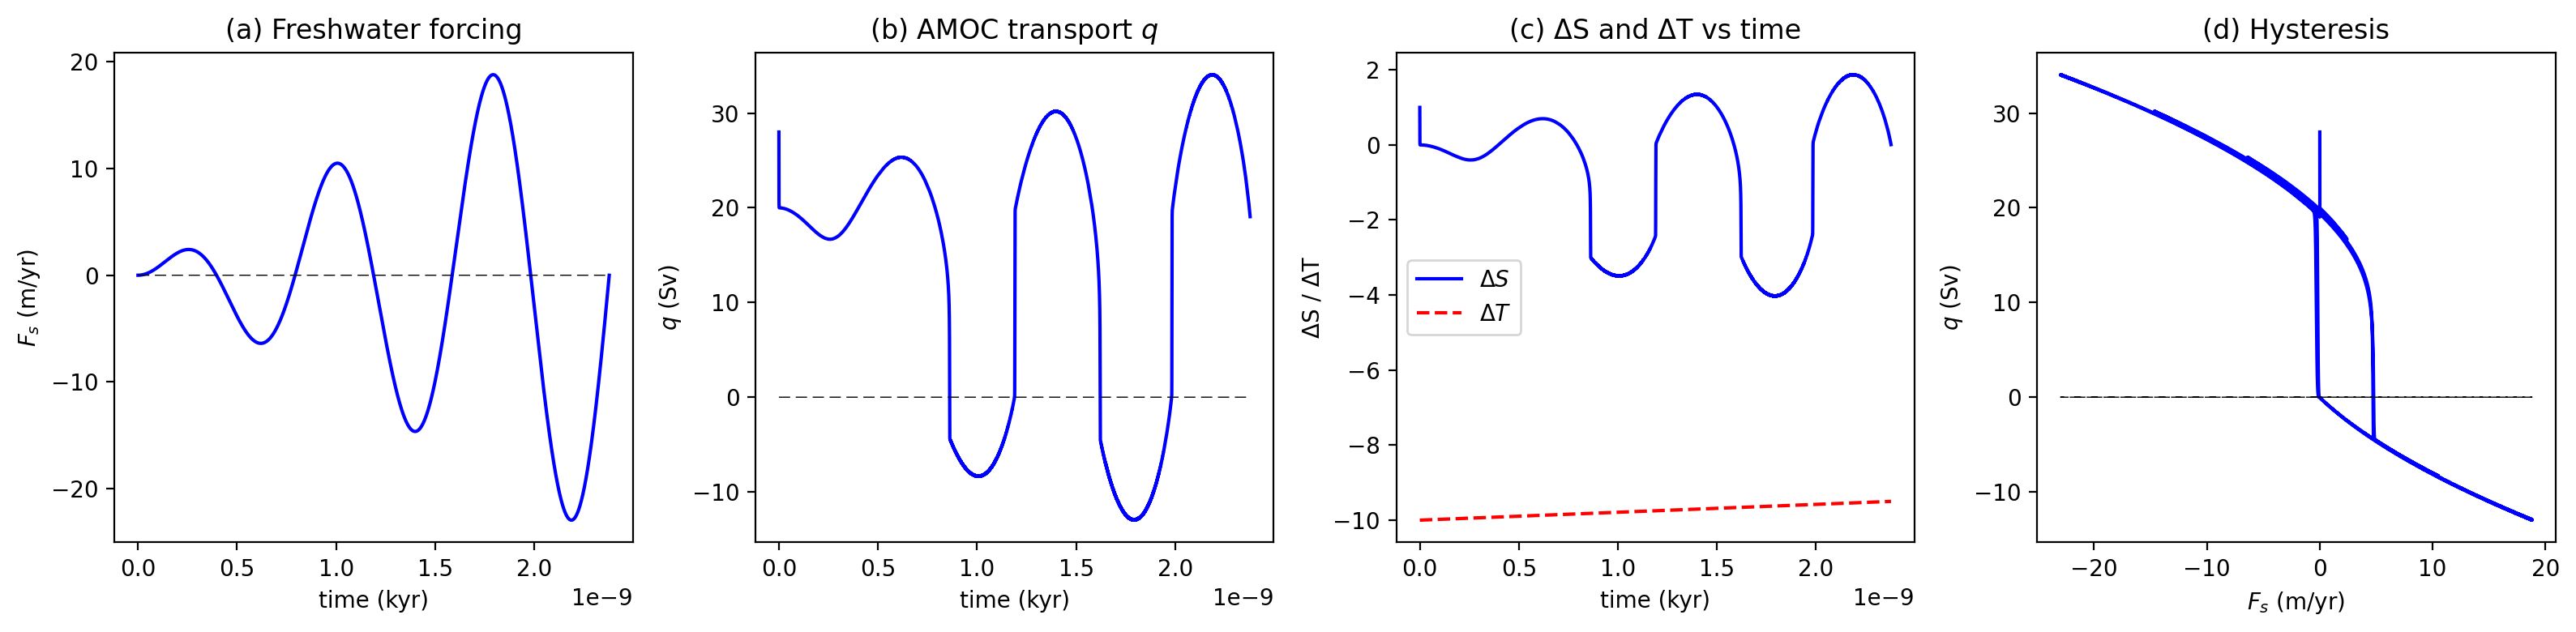

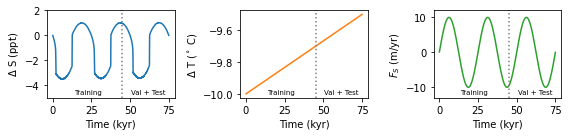

On: 70254, Off: 28743, Tipping: 940


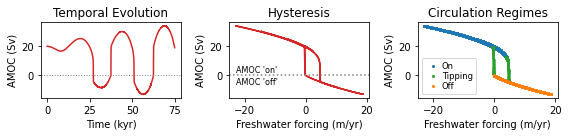

In [2]:
%run 00_generate_data.ipynb

In [3]:
def return_region_stats(forcing_type, model_type, i):
    preds, output_data = get_all_preds(forcing_type, model_type)
    
    predicted_labels = (preds[i, :] > 0.5).astype(int)
    false_indices = np.where(predicted_labels != output_data)

    # Adjust indices based on model type and forcing
    if model_type != "mlp":
        if forcing_type == "s":
            offset = 15  # lstm/transformer stationary
        elif model_type == "lstm":
            offset = 31  # lstm nonstationary
        else:
            offset = 63  # transformer nonstationary
    else:
        offset = 0

    # Misclassified points in each region
    
    tipping_mis = np.intersect1d(false_indices[0] + offset, indices['indices_tipping'])
    on_mis = np.intersect1d(false_indices[0] + offset, indices['indices_on'])
    off_mis = np.intersect1d(false_indices[0] + offset, indices['indices_off'])

    # Safely compute percentages
    on_acc = 100 * (1 - len(on_mis) / len(indices_on)) if len(indices_on) > 0 else np.nan
    off_acc = 100 * (1 - len(off_mis) / len(indices_off)) if len(indices_off) > 0 else np.nan
    tipping_acc = 100 * (1 - len(tipping_mis) / len(indices_tipping)) if len(indices_tipping) > 0 else np.nan
    
    return on_acc, off_acc, tipping_acc
    
    print(i+1)
    print(f"The {model_type.upper()} has 'on' accuracy of: {on_acc:.2f}%")
    print(f"The {model_type.upper()} has 'off' accuracy of: {off_acc:.2f}%")
    print(f"The {model_type.upper()} has 'tipping' accuracy of: {tipping_acc:.2f}%")

In [4]:
def get_shap_regions(forcing_type, model_type):
    _, shap_ensemble, _, sample_indices = get_ensemble_shap_vals(forcing_type, model_type)
    all_members_counts = []
    mask_on, mask_off, mask_tipping = get_masks(forcing_type)
    indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]
    for i in range(12):
        sal_shap = shap_ensemble[i, :, 1]  # salinity
        temp_shap = shap_ensemble[i, :, 2]  # temperature

        # Boolean masks for each region
        mask_tipping = np.isin(sample_indices, indices_tipping)
        mask_on = np.isin(sample_indices, indices_on)
        mask_off = np.isin(sample_indices, indices_off)

        # Count sal/temp dominance per region
        tipping_sal = np.sum(sal_shap[mask_tipping] > temp_shap[mask_tipping])
        tipping_temp = np.sum(sal_shap[mask_tipping] <= temp_shap[mask_tipping])

        on_sal = np.sum(sal_shap[mask_on] > temp_shap[mask_on])
        on_temp = np.sum(sal_shap[mask_on] <= temp_shap[mask_on])

        off_sal = np.sum(sal_shap[mask_off] > temp_shap[mask_off])
        off_temp = np.sum(sal_shap[mask_off] <= temp_shap[mask_off])

        # Compute percentages safely (avoid division by zero)
        def percent(n, total):
            return 100 * n / total if total > 0 else np.nan

        shap_counts = {
            "tipping": {
                "sal": tipping_sal, "sal_pct": percent(tipping_sal, tipping_sal + tipping_temp),
                "temp": tipping_temp, "temp_pct": percent(tipping_temp, tipping_sal + tipping_temp)
            },
            "on": {
                "sal": on_sal, "sal_pct": percent(on_sal, on_sal + on_temp),
                "temp": on_temp, "temp_pct": percent(on_temp, on_sal + on_temp)
            },
            "off": {
                "sal": off_sal, "sal_pct": percent(off_sal, off_sal + off_temp),
                "temp": off_temp, "temp_pct": percent(off_temp, off_sal + off_temp)
            }
        }
#         print(f'Ensemble member {i+1}:')
#         for region, counts in shap_counts.items():
#             print(f'  {region.capitalize()} - Sal: {counts["sal"]} ({counts["sal_pct"]:.1f}%), '
#                   f'Temp: {counts["temp"]} ({counts["temp_pct"]:.1f}%)')
#         print('-' * 50)

        all_members_counts.append(shap_counts)

    return all_members_counts

In [5]:
def get_lrp_regions_sample(forcing_type, model_type):
    
    lrp_ensemble = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    _, _, _, sample_indices = get_ensemble_shap_vals(forcing_type, model_type)
    
    if model_type == 'lstm':
        lrp_data = lrp_ensemble[:, :, -1, :]
    else:
        lrp_data = lrp_ensemble[:, :, :]
        
    
    all_members_counts = []
    mask_on, mask_off, mask_tipping = get_masks(forcing_type)
    indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]
    for i in range(12):
        sal_lrp = lrp_data[i, sample_indices, 1]  # salinity
        temp_lrp = lrp_data[i, sample_indices, 2]  # temperature

        # Boolean masks for each region
        mask_tipping = np.isin(sample_indices, indices_tipping)
        mask_on = np.isin(sample_indices, indices_on)
        mask_off = np.isin(sample_indices, indices_off)

        # Count sal/temp dominance per region
        tipping_sal = np.sum(sal_lrp[mask_tipping] > temp_lrp[mask_tipping])
        tipping_temp = np.sum(sal_lrp[mask_tipping] <= temp_lrp[mask_tipping])

        on_sal = np.sum(sal_lrp[mask_on] > temp_lrp[mask_on])
        on_temp = np.sum(sal_lrp[mask_on] <= temp_lrp[mask_on])

        off_sal = np.sum(sal_lrp[mask_off] > temp_lrp[mask_off])
        off_temp = np.sum(sal_lrp[mask_off] <= temp_lrp[mask_off])

        # Compute percentages safely (avoid division by zero)
        def percent(n, total):
            return 100 * n / total if total > 0 else np.nan

        lrp_counts = {
            "tipping": {
                "sal": tipping_sal, "sal_pct": percent(tipping_sal, tipping_sal + tipping_temp),
                "temp": tipping_temp, "temp_pct": percent(tipping_temp, tipping_sal + tipping_temp)
            },
            "on": {
                "sal": on_sal, "sal_pct": percent(on_sal, on_sal + on_temp),
                "temp": on_temp, "temp_pct": percent(on_temp, on_sal + on_temp)
            },
            "off": {
                "sal": off_sal, "sal_pct": percent(off_sal, off_sal + off_temp),
                "temp": off_temp, "temp_pct": percent(off_temp, off_sal + off_temp)
            }
        }
#         print(f'Ensemble member {i+1}:')
#         for region, counts in shap_counts.items():
#             print(f'  {region.capitalize()} - Sal: {counts["sal"]} ({counts["sal_pct"]:.1f}%), '
#                   f'Temp: {counts["temp"]} ({counts["temp_pct"]:.1f}%)')
#         print('-' * 50)

        all_members_counts.append(lrp_counts)

    return all_members_counts

In [6]:
input_data, output_data, qplot = get_data('ns')
stable_on = np.where(qplot/Sv > 27)
stable_off = np.where(qplot/Sv < -8)
stable_points_ns = np.hstack([stable_on[0], stable_off[0]])

def get_lrp_regions_sample(forcing_type, model_type):
    
    lrp_ensemble = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    _, _, _, sample_indices = get_ensemble_shap_vals(forcing_type, model_type)
    
    if model_type == 'lstm':
        lrp_data = lrp_ensemble[:, :, -1, :]
    else:
        lrp_data = lrp_ensemble[:, :, :]
    
    all_members_counts = []
    mask_on, mask_off, mask_tipping = get_masks(forcing_type)
    indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]
    
    # Filter On/Off to only include stable points
    stable_points_set = set(stable_points_ns)
    indices_on = np.array([idx for idx in indices_on if idx in stable_points_set])
    indices_off = np.array([idx for idx in indices_off if idx in stable_points_set])
    # Tipping remains the same
    
    for i in range(12):
        sal_lrp = lrp_data[i, sample_indices, 1]  # salinity
        temp_lrp = lrp_data[i, sample_indices, 2]  # temperature
        
        # Boolean masks for each region
        mask_tipping = np.isin(sample_indices, indices_tipping)
        mask_on = np.isin(sample_indices, indices_on)
        mask_off = np.isin(sample_indices, indices_off)
        
        # Count sal/temp dominance per region
        tipping_sal = np.sum(sal_lrp[mask_tipping] > temp_lrp[mask_tipping])
        tipping_temp = np.sum(sal_lrp[mask_tipping] <= temp_lrp[mask_tipping])
        on_sal = np.sum(sal_lrp[mask_on] > temp_lrp[mask_on])
        on_temp = np.sum(sal_lrp[mask_on] <= temp_lrp[mask_on])
        off_sal = np.sum(sal_lrp[mask_off] > temp_lrp[mask_off])
        off_temp = np.sum(sal_lrp[mask_off] <= temp_lrp[mask_off])
        
        # Compute percentages safely (avoid division by zero)
        def percent(n, total):
            return 100 * n / total if total > 0 else np.nan
        
        lrp_counts = {
            "tipping": {
                "sal": tipping_sal, "sal_pct": percent(tipping_sal, tipping_sal + tipping_temp),
                "temp": tipping_temp, "temp_pct": percent(tipping_temp, tipping_sal + tipping_temp)
            },
            "on": {
                "sal": on_sal, "sal_pct": percent(on_sal, on_sal + on_temp),
                "temp": on_temp, "temp_pct": percent(on_temp, on_sal + on_temp)
            },
            "off": {
                "sal": off_sal, "sal_pct": percent(off_sal, off_sal + off_temp),
                "temp": off_temp, "temp_pct": percent(off_temp, off_sal + off_temp)
            }
        }
        
        all_members_counts.append(lrp_counts)
    
    return all_members_counts

In [7]:
def get_lrp_regions(forcing_type, model_type):
    lrp_ensemble = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    
    if model_type == 'lstm':
        lrp_data = lrp_ensemble[:, :, -1, :]
    else:
        lrp_data = lrp_ensemble[:, :, :]

    # Method 1: Normalize each data point by its own max absolute value
    lrp_ensemble_v1 = lrp_data / (np.max(np.abs(lrp_data), axis=2, keepdims=True) + 1e-8)

#     # Method 2: Normalize each feature globally by its max absolute value
#     lrp_ensemble_v2 = np.zeros_like(lrp_data, dtype=float)
#     for feature in range(lrp_data.shape[2]):
#         feature_data = lrp_data[:, :, feature]
#         max_abs = np.abs(feature_data).max()
#         lrp_ensemble_v2[:, :, feature] = feature_data / (max_abs + 1e-8)
    
    lrp_ensemble = lrp_ensemble_v2

    
    all_members_counts = []
    mask_on, mask_off, mask_tipping = get_masks(forcing_type)
    if model_type == "lstm":
        if forcing_type == "s":
            mask_on = mask_on[15:]
            mask_off = mask_off[15:]
            mask_tipping = mask_tipping[15:]
            indices_on, indices_off, indices_tipping = np.arange(0, 100000-15, 1)[mask_on], np.arange(0, 100000-15, 1)[mask_off], np.arange(0, 100000-15, 1)[mask_tipping]
        else:
            mask_on = mask_on[31:]
            mask_off = mask_off[31:]
            mask_tipping = mask_tipping[31:]
            indices_on, indices_off, indices_tipping = np.arange(0, 100000-31, 1)[mask_on], np.arange(0, 100000-31, 1)[mask_off], np.arange(0, 100000-31, 1)[mask_tipping]
    else:
        indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]
    for i in range(12):
        lrp_i = lrp_ensemble[i, :, :]
        #lrp_min = lrp_i.min()
        #lrp_max = lrp_i.max()
        #lrp_norm = (lrp_i - lrp_min) / (lrp_max - lrp_min)
        lrp_norm = lrp_ensemble

        #lrp_sal = lrp_norm[:, 1]
        #lrp_temp = lrp_norm[:, 2]
        sal_lrp = lrp_norm[:, 1]  # salinity
        temp_lrp = lrp_norm[:, 2]  # temperature

        # Boolean masks for each region
        #mask_tipping = np.isin(sample_indices, indices_tipping)
        #mask_on = np.isin(sample_indices, indices_on)
        #mask_off = np.isin(sample_indices, indices_off)

        # Count sal/temp dominance per region
        tipping_sal = np.sum(sal_lrp[mask_tipping] > temp_lrp[mask_tipping])
        tipping_temp = np.sum(sal_lrp[mask_tipping] <= temp_lrp[mask_tipping])

        on_sal = np.sum(sal_lrp[mask_on] > temp_lrp[mask_on])
        on_temp = np.sum(sal_lrp[mask_on] <= temp_lrp[mask_on])

        off_sal = np.sum(sal_lrp[mask_off] > temp_lrp[mask_off])
        off_temp = np.sum(sal_lrp[mask_off] <= temp_lrp[mask_off])

        # Compute percentages safely (avoid division by zero)
        def percent(n, total):
            return 100 * n / total if total > 0 else np.nan

        lrp_counts = {
            "tipping": {
                "sal": tipping_sal, "sal_pct": percent(tipping_sal, tipping_sal + tipping_temp),
                "temp": tipping_temp, "temp_pct": percent(tipping_temp, tipping_sal + tipping_temp)
            },
            "on": {
                "sal": on_sal, "sal_pct": percent(on_sal, on_sal + on_temp),
                "temp": on_temp, "temp_pct": percent(on_temp, on_sal + on_temp)
            },
            "off": {
                "sal": off_sal, "sal_pct": percent(off_sal, off_sal + off_temp),
                "temp": off_temp, "temp_pct": percent(off_temp, off_sal + off_temp)
            }
        }
#         print(f'Ensemble member {i+1}:')
#         for region, counts in shap_counts.items():
#             print(f'  {region.capitalize()} - Sal: {counts["sal"]} ({counts["sal_pct"]:.1f}%), '
#                   f'Temp: {counts["temp"]} ({counts["temp_pct"]:.1f}%)')
#         print('-' * 50)

        all_members_counts.append(lrp_counts)

    return all_members_counts

In [396]:
def plot_avg_counts(forcing_type, model_type):
    # Get SHAP percentages for all ensemble members
    shap_counts_per_member = get_shap_regions(forcing_type, model_type)  # example

    regions = ["tipping", "on", "off"]

    # Collect percentages across ensemble members
    sal_vals = {region: [] for region in regions}
    temp_vals = {region: [] for region in regions}

    for member_counts in shap_counts_per_member:
        for region in regions:
            sal_vals[region].append(member_counts[region]["sal_pct"])
            temp_vals[region].append(member_counts[region]["temp_pct"])

    # Compute mean and std for each feature in each region
    sal_mean = [np.mean(sal_vals[region]) for region in regions]
    sal_std = [np.std(sal_vals[region]) for region in regions]

    temp_mean = [np.mean(temp_vals[region]) for region in regions]
    temp_std = [np.std(temp_vals[region]) for region in regions]

    # Plot stacked bar chart
    x = np.arange(len(regions))
    width = 0.6

    fig, ax = plt.subplots(figsize=(7,5))

    # Bottom bar = temperature
    ax.bar(x, temp_mean, width, yerr=temp_std, label='Temperature', color='tab:orange', capsize=5)

    # Top bar = salinity
    ax.bar(x, sal_mean, width, bottom=temp_mean, yerr=sal_std, label='Salinity', color='tab:blue', capsize=5)

    ax.set_xticks(x)
    ax.set_xticklabels([r.capitalize() for r in regions])
    ax.set_ylabel('SHAP Dominance (%)')
    ax.set_title('Feature Dominance Across Regions in ' + str.upper(model_type) + ' (' + str.upper(forcing_type) + ')')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [429]:
def plot_member_counts(forcing_type, model_type, tosave=True):
    # Get SHAP percentages for all ensemble members
    shap_counts_per_member = get_lrp_regions(forcing_type, model_type)
    regions = ["on", "tipping", "off"]
    x = np.arange(len(regions))
    width = 0.6

    fig, axes = plt.subplots(3, 4, figsize=(7, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(shap_counts_per_member):
            ax.axis('off')
            continue

        member_counts = shap_counts_per_member[i]
        sal_pct = [member_counts[r]["sal_pct"] for r in regions]
        temp_pct = [member_counts[r]["temp_pct"] for r in regions]

        # Plot stacked bars for each ensemble member
        ax.bar(x, temp_pct, width, color='tab:orange', label='Temperature')
        ax.bar(x, sal_pct, width, bottom=temp_pct, color='tab:blue', label='Salinity')

        ax.set_xticks(x)
        ax.set_xticklabels([r.capitalize() for r in regions])
        ax.set_ylim(0, 100)
        ax.set_title(f'Member {i+1}', fontsize=10)
        if i == 4:
            ax.set_ylabel('LRP Dominance (%)')
            
#         on_acc, off_acc, tipping_acc = return_region_stats(forcing_type, model_type, i)    
#         textstr = (
#                 f"TIPPING: {tipping_acc:.1f}%\n"
#                 f"ON: {on_acc:.1f}%\n"
#                 f"OFF: {off_acc:.1f}%\n"
#             )
#         ax.text(
#                 0.5, -0.3, textstr,
#                 transform=ax.transAxes,
#                 ha='center', va='top',
#                 fontsize=9, family='monospace'
#             )

    # Add a single legend outside the grid
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))

    #fig.suptitle(f'Feature Dominance Across Regions\n{model_type.upper()} ({forcing_type.upper()})', fontsize=14)
    plt.tight_layout()
    return fig
    #plt.show()


On: 70274, Off: 28743, Tipping: 983
on: 7999
off: 5278


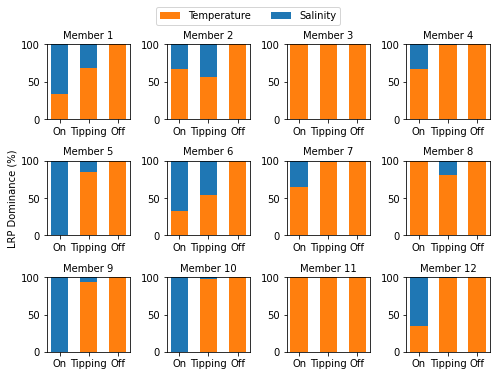

In [436]:
fig = plot_member_counts('ns', 'lstm')

In [437]:
fig.savefig('figures/lrp/lstm_ns_bar.pdf', bbox_inches='tight')

In [10]:
def get_masks(forcing_type):
    input_data, output_data, qplot = get_data(forcing_type)
    grad = np.gradient(qplot / Sv)
    qp = qplot / Sv

    mask_tipping = np.abs(grad) > 0.01
    mask_on = (qp > 0.0)
    mask_off = (qp < 0.0)

    # enforce mutual exclusivity
    mask_tipping = mask_tipping
    mask_on = mask_on & ~mask_tipping
    mask_off = mask_off & ~(mask_tipping | mask_on)

    # sanity check: no overlap and full coverage
    assert not np.any(mask_on & mask_off), "Overlap between ON and OFF"
    assert not np.any(mask_on & mask_tipping), "Overlap between ON and TIPPING"
    assert not np.any(mask_off & mask_tipping), "Overlap between OFF and TIPPING"

    # optionally print region sizes
    print(f"On: {mask_on.sum()}, Off: {mask_off.sum()}, Tipping: {mask_tipping.sum()}")

    return mask_on, mask_off, mask_tipping


**Layer-wise relevance propagation plotting functions**

In [11]:
def plot_lrp_time_fwf(forcing_type, model_type):
    
    """
    Generate a figure with two subplots of layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).

    Returns
    -------
    None
        Displays a figure with:
        - y-axis: layer-wise relevance values
        - x-axis: time and freshwater forcing
    """

    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    
    fig.suptitle('Layer-wise Relevance Propagation for ' + str.upper(model_type) + ' ensemble')
    
    ax[0].plot(input_data[:end, 0], lrp_sal_mean)
    ax[0].plot(input_data[:end, 0], lrp_temp_mean)
    ax[1].plot(input_data[:end, 3]/Fs_to_m_per_year, lrp_sal_mean)
    ax[1].plot(input_data[:end, 3]/Fs_to_m_per_year, lrp_temp_mean)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Relevance')
    ax[1].set_xlabel('Freshwater Forcing')
    ax[1].set_ylabel('Relevance')
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')
    
    return fig;

In [286]:
def plot_lrp_time(model_type):
    """
    Compare median LRP(ΔT) and LRP(ΔS) contributions over time 
    for a single ensemble member across stationary and nonstationary forcings,
    including AMOC overlay.
    """
    # --- Model-specific offsets after 64-crop ---
    def get_offset(model_type, forcing_type):
        if model_type == "transformer" and forcing_type == "ns":
            return 63
        elif model_type == "lstm" and forcing_type == "ns":
            return 31
        elif forcing_type == "s" and model_type != "mlp":
            return 15
        else:
            return 0
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True)
    forcing_types = ["s", "ns"]
    twin_axes = []
    
    for j, forcing_type in enumerate(forcing_types):
        # --- Load data ---
        input_data, output_data, qplot = get_data(forcing_type)
        
        # Load LRP
        lrp = np.load(f'lrp_norm/lrp_{model_type}_{forcing_type}.npy')
            
        lrp_ens = lrp.mean(axis=0)  # shape: (100000, 4)
        
        
        # --- Apply model offset ---
        offset = get_offset(model_type, forcing_type)
        
        ax[j].plot(input_data[64:, 0], lrp_ens[64-offset:, 1], linewidth=2, color='tab:blue', label='LRP(ΔS)')
        ax[j].plot(input_data[64:, 0], lrp_ens[64-offset:, 2], linewidth=2, color='tab:orange', label='LRP(ΔT)')
        
        ax[j].set_xlabel("Time (kyr)")
        if j == 0:
            ax[j].set_ylabel("LRP values")
        ax[j].set_title("Stationary forcing" if forcing_type == "s" else "Nonstationary forcing")
        
        # --- Overlay AMOC ---
        ax_r = ax[j].twinx()
        ax_r.plot(input_data[64:, 0], qplot[64:]/Sv, linewidth=4, alpha=0.3, color='grey', label='Circulation')
        if j == 1:
            ax_r.set_ylabel("AMOC (Sv)")
        twin_axes.append(ax_r)
    
    # --- Combine legend from main and twin axes ---
    handles, labels = [], []
    for a in list(ax) + twin_axes:
        h, l = a.get_legend_handles_labels()
        handles += h
        labels += l
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(),
               loc="upper center", bbox_to_anchor=(0.5, -0.0001),
               ncol=3, frameon=False)
    
    
    fig.tight_layout()
    return fig

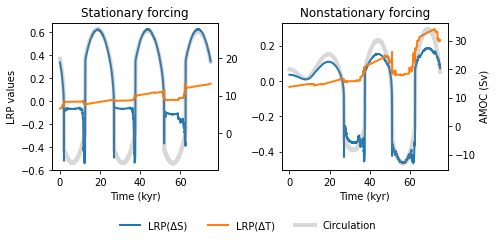

In [287]:
fig = plot_lrp_time('mlp')

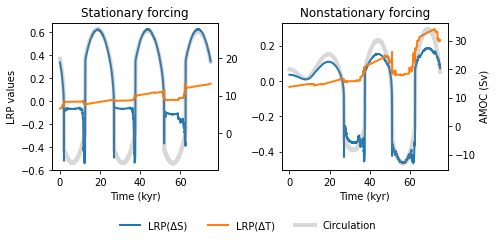

In [285]:
fig = plot_lrp_time('mlp')

In [14]:
def plot_lrp_time_individual(model_type, ensemble_member=0):
    """
    Compare median LRP(ΔT) and LRP(ΔS) contributions over time 
    for a single ensemble member across stationary and nonstationary forcings,
    including AMOC overlay.
    """
    # --- Model-specific offsets after 64-crop ---
    def get_offset(model_type, forcing_type):
        if model_type == "transformer" and forcing_type == "ns":
            return 63
        elif model_type == "lstm" and forcing_type == "ns":
            return 33
        elif forcing_type == "s" and model_type != "mlp":
            return 15
        else:
            return 0
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True)
    forcing_types = ["s", "ns"]
    twin_axes = []
    
    for j, forcing_type in enumerate(forcing_types):
        # --- Load data ---
        input_data, output_data, qplot = get_data(forcing_type)
        _, _, _, sample_indices = get_ensemble_shap_vals(forcing_type, model_type)
        
        # Load LRP
        lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
        
        # Extract single ensemble member
        if model_type == 'lstm':
            lrp = lrp[:, :, -1, :]
            
        lrp_member = lrp[ensemble_member, :, :]  # shape: (100000, 4)
        
        # Normalize by max absolute value per feature (like v2)
        lrp_member_norm = np.zeros_like(lrp_member, dtype=float)
        for feature in range(lrp_member.shape[1]):
            max_abs = np.abs(lrp_member[:, feature]).max()
            lrp_member_norm[:, feature] = lrp_member[:, feature] / (max_abs + 1e-8)
        
        # --- Apply global crop (always first 64 removed) ---
        crop = 64
        keep_mask = sample_indices >= crop
        sample_indices_crop = sample_indices[keep_mask]
        lrp_sal_mean = lrp_member_norm[sample_indices_crop, 1]
        lrp_temp_mean = lrp_member_norm[sample_indices_crop, 2]
        
        # --- Apply model offset ---
        offset = get_offset(model_type, forcing_type)
        input_data = input_data[offset:]
        qplot = qplot[offset:]
        sample_indices_crop = sample_indices_crop[sample_indices_crop < len(input_data)]
        
        # --- Extract relevant arrays ---
        time_vals = input_data[sample_indices_crop, 0]
        qplot_crop = qplot[crop:] / Sv
        
        # --- Compute median binned LRP values ---
        min_x, max_x = time_vals.min(), time_vals.max()
        spacing = (max_x - min_x) / 100
        valid_x, median_sal, median_temp = [], [], []
        
        for i in range(100):
            start_x = min_x + i * spacing
            end_x = start_x + spacing
            subset = np.where((time_vals >= start_x) & (time_vals < end_x))[0]
            if len(subset) == 0:
                continue
            valid_x.append((start_x + end_x) / 2)
            median_sal.append(np.median(lrp_sal_mean[subset]))
            median_temp.append(np.median(lrp_temp_mean[subset]))
        
        # --- Plot LRP contributions ---
        ax = axes[j]
        ax.plot(valid_x, median_sal, linewidth=2, color='tab:blue', label='LRP(ΔS)')
        ax.plot(valid_x, median_temp, linewidth=2, color='tab:orange', label='LRP(ΔT)')
        ax.set_xlabel("Time (kyr)")
        if j == 0:
            ax.set_ylabel("LRP values")
        ax.set_title("Stationary forcing" if forcing_type == "s" else "Nonstationary forcing")
        
        # --- Overlay AMOC ---
        ax_r = ax.twinx()
        ax_r.plot(input_data[crop:, 0], qplot_crop, linewidth=4, alpha=0.3, color='grey', label='Circulation')
        if j == 1:
            ax_r.set_ylabel("AMOC (Sv)")
        twin_axes.append(ax_r)
    
    # --- Combine legend from main and twin axes ---
    handles, labels = [], []
    for a in list(axes) + twin_axes:
        h, l = a.get_legend_handles_labels()
        handles += h
        labels += l
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(),
               loc="upper center", bbox_to_anchor=(0.5, -0.0001),
               ncol=3, frameon=False)
    
    fig.suptitle(f'LRP for {model_type.upper()} Ensemble Member {ensemble_member}', fontsize=12)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

In [16]:
def plot_lrp_time_fwf(forcing_type, model_type):
    
    """
    Generate a figure with two subplots of layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).

    Returns
    -------
    None
        Displays a figure with:
        - y-axis: layer-wise relevance values
        - x-axis: time and freshwater forcing
    """

    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    
    fig.suptitle('Layer-wise Relevance Propagation for ' + str.upper(model_type) + ' ensemble')
    
    ax[0].plot(input_data[:end, 0], lrp_sal_mean)
    ax[0].plot(input_data[:end, 0], lrp_temp_mean)
    ax[1].plot(input_data[:end, 3]/Fs_to_m_per_year, lrp_sal_mean)
    ax[1].plot(input_data[:end, 3]/Fs_to_m_per_year, lrp_temp_mean)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Relevance')
    ax[1].set_xlabel('Freshwater Forcing')
    ax[1].set_ylabel('Relevance')
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')
    
    return fig;

In [17]:
def plot_lrp_dominance_members(forcing_type, model_type, xaxis):
    """
    Generate a figure with 12 subplots of dominating layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).

    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing 
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp = lrp.mean(axis=2)
    fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
    if xaxis == "t":
        fig.supxlabel('Time')
    else:
        fig.supxlabel('Freshwater Forcing')
    fig.supylabel('AMOC')
    fig.suptitle('Comparing Relevance Values for ' + str.upper(model_type) + ' Ensemble Members')
    ax = ax.flatten()
    for i in range(12):
        lrp_i = lrp[i, :, :]
        lrp_temp = lrp_i[:, 2]
        lrp_sal = lrp_i[:, 1]
        colors = np.where(lrp_temp > lrp_sal, '#ff7f0e', '#1f77b4')
        if xaxis == "t":
            scatter = ax[i].scatter(input_data[:end, 0], qplot[:end]/Sv, 
                                c=colors, marker='o', s=18, alpha=0.5)
            ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
        else: 
            scatter = ax[i].scatter(input_data[:end, 3]/Fs_to_m_per_year, qplot[:end]/Sv, 
                                c=colors, marker='o', s=18, alpha=0.5)
            ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
        
        ax[i].axhline(0, color='black', linestyle='--')

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')
    
    return fig;

In [18]:
models = ['mlp', 'lstm']
forcings = ['s', 'ns']

for model in models:
    for forcing in forcings:
        filepath = f'lrp_npy/lrp_{model}_{forcing}.npy'
        
        # Load LRP data
        lrp = np.load(filepath)
        
        if model == 'lstm':
            # Extract last timestep for LSTM
            lrp_data = lrp[:, :, -1, :]
        else:
            lrp_data = lrp[:, :, :]
        
        # Normalize each feature globally by its max absolute value
        lrp_norm = np.zeros_like(lrp_data, dtype=float)
        for feature in range(lrp_data.shape[2]):
            feature_data = lrp_data[:, :, feature]
            max_abs = np.abs(feature_data).max()
            lrp_norm[:, :, feature] = feature_data / (max_abs + 1e-8)
        
        # Save normalized LRP
        output_path = f'lrp_norm/lrp_{model}_{forcing}.npy'
        np.save(output_path, lrp_norm)

In [19]:
def plot_lrp_dominance_ensemble(forcing_type, model_type, xaxis):
    """
    Generate a figure with dominating averaged (over the ensemble members) layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).
        
    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_norm/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=0)
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]
    
    fig, ax = plt.subplots()

    colors = np.where(lrp_temp_mean > lrp_sal_mean, '#ff7f0e', '#1f77b4')
    if xaxis == "t":
            scatter = ax.scatter(input_data[:end, 0], qplot[:end]/Sv, 
                        c=colors, marker='o', s=18)
    else: 
            scatter = ax.scatter(input_data[:end, 3]/Fs_to_m_per_year, qplot[:end]/Sv, 
                        c=colors, marker='o', s=18)

    if xaxis == "t":
        ax.set_xlabel('Time')
        ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
    else:
        ax.set_xlabel('Freshwater Forcing')
        ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
        
    ax.set_ylabel('AMOC')
    ax.set_title('Mean Relevance Values for ' + str.upper(model_type) + ' Ensemble')
    
    ax.axhline(0, color='black', linestyle='--')

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#ff7f0e', markersize=10),
                     plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#1f77b4', markersize=10)]
    ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
              loc='lower right')
    
    return fig;

In [20]:
def plot_lrp_time_gradient(forcing_type, model_type):
    """
    Generate a figure showing AMOC evolution and feature relevance over time.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).

    Returns
    -------
    None
        Displays a 2-panel figure:
        - Top: AMOC strength vs. time
        - Bottom: Layer-wise relevance (ΔSalinity, ΔTemperature) vs. time
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_matrix = lrp_avg[:, 1:3].T  
    time = input_data[:, 0]
    feature_names = ['$\Delta$ Salinity', '$\Delta$ Temperature']
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(time, qplot/Sv, color='black')
    ax[0].set_ylabel('AMOC')

    # Sort data by timea
    sorted_idx = np.argsort(time[:end])
    lrp_sorted = lrp_matrix[:, sorted_idx]
#     im = ax[1].imshow(
#         lrp_sorted,
#         aspect='auto',
#         cmap='coolwarm',
#         origin='lower',
#         interpolation='none'
#         #extent=[input_data[:,0].min(), input_data[:,0].max(), 0, len(feature_names)]
#     )

    vmin, vmax = np.percentile(lrp_sorted, [1, 99])
    im = ax[1].imshow(
        lrp_sorted,
        aspect='auto',
        cmap='coolwarm',
        origin='lower',
        interpolation='none',
        extent=[time.min(), time.max(), 0, len(feature_names)],
        vmin=vmin,
        vmax=vmax
    )




    # Y-axis: feature labels
    ax[1].set_yticks(np.arange(len(feature_names)) + 0.5)
    ax[1].set_yticklabels(feature_names)
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Features")

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Relevance")
    
    #fig.suptitle('Time Evolution of Relevance for ' + str.upper(model_type) + ' Ensemble')
    
    return fig;

In [21]:
def plot_lrp_time_gradient(forcing_type, model_type, save_path=None):
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    
    #lrp_matrix = lrp_avg[:, 1:3].T  
    lrp_matrix = lrp_avg.T
    time = input_data[:, 0]
    #feature_names = ['$\Delta$ Salinity', '$\Delta$ Temperature']
    feature_names = ['Time', '$\Delta$ Salinity', '$\Delta$ Temperature', 'Freshwater Forcing']

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True, dpi=200, sharex=True)

    # Top: AMOC
    ax[0].plot(time, qplot/Sv, color='black')
    ax[0].set_ylabel('AMOC')
    #ax[0].plot(time, lrp_avg[:, 1], label='Temp LRP')
    #ax[0].plot(time, lrp_avg[:, 2], label='Sal LRP')

    # Bottom: LRP heatmap
    sorted_idx = np.argsort(time[:end])
    lrp_sorted = lrp_matrix[:, sorted_idx]
    vmin, vmax = np.percentile(lrp_sorted, [1, 99])

    # Plot without extent
    im = ax[1].imshow(
        lrp_sorted,
        aspect='auto',          # stretch horizontally to fill axes
        cmap='coolwarm',
        origin='lower',
        interpolation='none',
        vmin=vmin,
        vmax=vmax
    )
    
    # Y-axis: categorical feature labels
    ax[1].set_yticks(np.arange(len(feature_names)))
    ax[1].set_yticklabels(feature_names)
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Features")

    # Align x-axis with time
    #ax[1].set_xticks(np.linspace(0, lrp_sorted.shape[1]-1, 5))
    #ax[1].set_xticklabels([f"{time[int(i)]:.0f}" for i in np.linspace(0, lrp_sorted.shape[1]-1, 5)])

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Relevance")
    
    fig.suptitle('Time Evolution of Relevance for ' + str.upper(model_type) + ' Ensemble')

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    
    return fig


In [22]:
def plot_lrp_fwf_gradient(forcing_type, model_type):
    """
    Generate a figure showing AMOC evolution and feature relevance over freshwater forcing.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).

    Returns
    -------
    None
        Displays a 2-panel figure:
        - Top: AMOC strength vs. freshwater forcing
        - Bottom: Layer-wise relevance (ΔSalinity, ΔTemperature) vs. time
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_matrix = lrp_avg[:, 1:3].T  
    fwf = input_data[:, 3]
    feature_names = ['$\Delta$ Salinity', '$\Delta$ Temperature']
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(fwf/Fs_to_m_per_year, qplot/Sv, color='black')
    ax[0].set_ylabel('AMOC')

    # Sort data by timea
    sorted_idx = np.argsort(fwf[:end])
    lrp_sorted = lrp_matrix[:, sorted_idx]
    #vmin, vmax = np.percentile(lrp_sorted, [1, 99])
    im = ax[1].imshow(
        lrp_sorted,
        aspect='auto',
        cmap='coolwarm',
        origin='lower',
        interpolation='none'
        #vmin=vmin,
        #vmax=vmax
        #extent=[input_data[:,3].min(), input_data[:,3].max(), 0, len(feature_names)]
    )


    # Y-axis: feature labels
    ax[1].set_yticks(np.arange(len(feature_names)) + 0.5)
    ax[1].set_yticklabels(feature_names)
    ax[1].set_xlabel("Freshwater Forcing")
    ax[1].set_ylabel("Features")

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Relevance")
    
    fig.suptitle('Evolution of Relevance for ' + str.upper(model_type) + ' Ensemble with respect to Freshwater Forcing')
    

    return fig

In [23]:
def plot_lrp_lstm_steps(forcing_type):
    """
    Generate a figure with dominating averaged (over the ensemble members) layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).
        
    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_lstm_{forcing_type}.npy')
    end = len(input_data)
    if forcing_type == "s":
        end = 100000 - 16 + 1 
        fig, ax = plt.subplots(4, 4, figsize=(20, 15))
    else:
        end = 100000 - 32 + 1
        fig, ax = plt.subplots(8, 4, figsize=(20, 15))
        
    lrp_avg = lrp.mean(axis=0)
    lrp_sal_mean = lrp_avg[:, :, 1]
    lrp_temp_mean = lrp_avg[:, :, 2]
    ax = ax.flatten()
    
    for i in range(len(ax)):
        ax[i].plot(lrp_sal_mean[:, i], label='salinity lrp');
        ax[i].plot(lrp_temp_mean[:, i], label='temp lrp');
        
    fig.supylabel('Relevance')
    fig.supxlabel('Time step')
    fig.suptitle('Time Step Relevance Values for LSTM Ensemble')
    

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#ff7f0e', markersize=10),
                     plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#1f77b4', markersize=10)]
    ax[-1].legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
              loc='lower right')
    

**SHAP plotting functions**

In [24]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

In [25]:
def data_for_shap_ts(forcing_type, model_type):
    
    if forcing_type == "s":
        time_steps = 16
    else:
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
            
    # getting data
    input_data, output_data, qplot = get_data(forcing_type)
    X_train = input_data[0:60032]
    y_train = output_data[0:60032]
    X_val = input_data[61024:81000]
    y_val = output_data[61024:81000]
    X_test = input_data[81992:100000]
    y_test = output_data[81992:100000]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    input_scaled = scaler.transform(input_data)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
    input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)
    
    num_sequences = input_seq.shape[0]
    
    # data for SHAP
    background_data = shap.kmeans(X_train_seq.reshape(X_train_seq.shape[0], -1), 10)
    
    # for reproducibility
    rng = np.random.default_rng(seed=42)
    qplot_smooth = qplot / Sv
    seq_grad = np.array([
    np.mean(np.abs(np.gradient(qplot_smooth[i:i+time_steps])))
    for i in range(num_sequences)
    ])
    seq_probs = seq_grad / seq_grad.sum()
    sample_size = 1000
    sample_start_indices = rng.choice(num_sequences, size=1000, replace=False, p=seq_probs)

    input_sample = input_seq[sample_start_indices]
    
    return background_data, input_sample, sample_start_indices + time_steps - 1

In [26]:
def data_for_shap(forcing_type, model_type):
    
    # getting data
    input_data, output_data, qplot = get_data(forcing_type)
    X_train = input_data[0:60032]
    y_train = output_data[0:60032]
    X_val = input_data[61024:81000]
    y_val = output_data[61024:81000]
    X_test = input_data[81992:100000]
    y_test = output_data[81992:100000]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    input_scaled = scaler.transform(input_data)
    
    # data for SHAP
    background_data = shap.kmeans(X_train_scaled, 50)
    
    # for reproducibility
    rng = np.random.default_rng(seed=42)
    qplot_smooth = qplot / Sv
    q_gradient = np.abs(np.gradient(qplot_smooth))
    gradient_probs = q_gradient / q_gradient.sum()

    sample_indices = rng.choice(len(qplot), size=1000, replace=False, p=gradient_probs)
    input_sample = input_scaled[sample_indices]
    
    return background_data, input_sample, sample_indices

In [27]:
def build_transformer():
    inputs = Input(shape=(None, 4))  # None allows variable sequence length
    
   
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=4,
        dropout=0.1
    )(inputs, inputs)  

    pooled = GlobalAveragePooling1D()(attention_output)

    x = Dense(16, activation='relu')(pooled)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(2, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model 

def get_models(forcing_type, model_type):
    forcing = "stationary"
    if forcing_type == "ns":
        forcing = "nonstationary"
    
    if forcing_type == "s":
        time_steps = 16
    else:
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
            
    models = []
    if model_type == "mlp":
        for i in range(12):
            model = Sequential()
            model.add(Dense(4, input_dim=4, activation='relu'))
            model.add(Dense(2, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
    elif model_type == "lstm":
        for i in range(12):
            model = Sequential([
            LSTM(8, input_shape=(time_steps, 4), return_sequences=False),
            Dense(4, activation='relu'),
            Dense(2, activation='relu'),
            Dense(1, activation='sigmoid') 
            ])
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
    elif model_type == "transformer":
        for i in range(12):
            model = build_transformer()
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
        
    return models

In [28]:
def get_ensemble_shap_vals(forcing_type, model_type):
    
    shap_vals = np.load(f'shap_npy/shap_{model_type}_{forcing_type}.npy')
    input_data, output_data, qplot = get_data(forcing_type)
    
    if model_type == "mlp":
        shap_ensemble = shap_vals.squeeze()
        background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
        qsample = qplot[sample_indices]
        
    elif model_type == "lstm":
        if forcing_type == "s":
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 16, 4)[:, :, -1, :]
        else:
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 32, 4)[:, :, -1, :]
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, -1, :]   # take last time step
        qsample = qplot[sample_indices]
        
    elif model_type == "transformer":
        if forcing_type == "s":
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 16, 4)[:, :, -1, :]
        else:
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 64, 4)[:, :, -1, :]
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, -1, :]   # take last time step
        qsample = qplot[sample_indices]
    
    return input_sample, shap_ensemble, qsample, sample_indices


In [29]:
def get_avg_shap_vals(forcing_type, model_type):
    
    shap_vals = np.load(f'shap_npy/shap_{model_type}_{forcing_type}.npy')
    
    if model_type == "mlp":
        shap_sal_mean = shap_vals.squeeze().mean(axis=0)[:, 1]
        shap_temp_mean = shap_vals.squeeze().mean(axis=0)[:, 2]
        background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
    elif model_type == "lstm":
        if forcing_type == "s":
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4)[:, :, -1, 1].mean(axis=0)
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4)[:, :, -1, 2].mean(axis=0)
        else:
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 32, 4)[:, :, -1, 1].mean(axis=0)
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 32, 4)[:, :, -1, 2].mean(axis=0)
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, 0, :]
    elif model_type == "transformer":
        if forcing_type == "s":
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4)[:, :, -1, 1].mean(axis=0)
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4)[:, :, -1, 2].mean(axis=0)
        else:
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 64, 4)[:, :, -1, 1].mean(axis=0)
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 64, 4)[:, :, -1, 2].mean(axis=0)
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, 0, :]
    
    return input_sample, shap_sal_mean, shap_temp_mean, sample_indices

In [30]:
def get_predictions(forcing_type, model_type):
    models = get_models(forcing_type, model_type)
    if model_type != "mlp":
        _, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
    else:
        input_sample, _, _, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    _, output_data, _ = get_data(forcing_type)
    output_sample = output_data[sample_indices]
    if model_type != "mlp":
        if forcing_type == "s":
            sample_indices = sample_indices + 15
        elif model_type == "lstm":
            sample_indices = sample_indices + 31
        else:
            sample_indices = sample_indices + 63
    
    predicted_results_ensemble = np.nan * np.zeros((12, input_sample.shape[0], 1))
    
    for i in range(12):
        print(i)
        model_i = models[i]
        model_i.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        loss, accuracy= model_i.evaluate(input_sample, output_sample)
        print(f'Sample loss: {loss}')
        print(f'Sample accuracy: {accuracy}')
        predicted = model_i.predict(input_sample)
        predicted_results_ensemble[i,...] = predicted
    
    return predicted_results_ensemble.squeeze()
        
    if model_type != "mlp":
        return np.mean(predicted_results_ensemble, axis=0).reshape(-1)
    
    return predicted_results_ensemble.mean(axis=0).squeeze()

In [31]:
def plot_shap_time_fwf(forcing_type, model_type):
    
    input_sample, shap_sal_mean, shap_temp_mean, _ = get_avg_shap_vals(forcing_type, model_type)
            
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle('SHAP')

    ax[0].scatter(input_sample[:, 0], shap_sal_mean)
    ax[0].scatter(input_sample[:, 0], shap_temp_mean)
    ax[1].scatter(input_sample[:, 3]/Fs_to_m_per_year, shap_sal_mean)
    ax[1].scatter(input_sample[:, 3]/Fs_to_m_per_year, shap_temp_mean)
    ax[0].set_xlabel('Time (in kyr)')
    ax[0].set_ylabel('SHAP Value')
    ax[1].set_xlabel('Freshwater Forcing (m/yr)')
    ax[1].set_ylabel('SHAP Value')
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')
    if model_type == "mlp":
        fig.suptitle('MLP Ensemble');
    elif model_type == "lstm":
        fig.suptitle('LSTM Ensemble');
    else:
        fig.suptitle('Transformer Ensemble');
    return fig

In [32]:
def plot_shap_dominance_members(forcing_type, model_type, xaxis):
    """
    Generate a figure with 12 subplots of dominating layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).

    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing 
    """
    input_sample, shap_ensemble, qsample, sample_indices = get_ensemble_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)
    
    fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
    if xaxis == "t":
        fig.supxlabel('Time (kyr)')
    else:
        fig.supxlabel('Freshwater Forcing (m/yr)')
    fig.supylabel('AMOC (Sv)')
    fig.suptitle('Dominating SHAP Values for Ensemble Members')
    ax = ax.flatten()
    for i in range(12):
        shap_i = shap_ensemble[i, :, :]
        shap_temp = shap_i[:, 2]
        shap_sal = shap_i[:, 1]
        colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')
        if xaxis == "t":
            scatter = ax[i].scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, 
                                c=colors, marker='o', s=18), #alpha=0.5)
            ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
        else: 
            scatter = ax[i].scatter(input_data[sample_indices, 3]/Fs_to_m_per_year, qplot[sample_indices]/Sv, 
                                c=colors, marker='o', s=18) #, alpha=0.5)
            ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
        
        ax[i].axhline(0, color='black', linestyle='--')
        ax[i].set_title('Ensemble Member ' + str(i+1))

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['SHAP ($\Delta T$)', 'SHAP ($\Delta S$)'], 
               loc='lower right')
    return fig

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confidence_members(forcing_type, model_type, xaxis):
    """
    Plot prediction confidence of 12 ensemble members, one per subplot.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm".
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).
    """
    input_sample, shap_sal_mean, shap_temp_mean, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)
    preds = get_predictions(forcing_type, model_type)
    
    fig, ax = plt.subplots(4, 3, figsize=(10, 10))
    ax = ax.flatten()
    
    if xaxis == "fwf":
        for i in range(12):
            sc = ax[i].scatter(input_data[sample_indices, 3]/Fs_to_m_per_year, qplot[sample_indices] / Sv, 
                      c=preds[i, :], cmap="plasma", s=10)
            ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot / Sv, color="grey", linestyle="--")
            cbar = plt.colorbar(sc, ax=ax[i], orientation="vertical", fraction=0.046, pad=0.02)
            ax[i].axhline(y=0, color='black', linestyle='dashed')
            ax[i].set_title(f'Ensemble Member {i+1}')
    else:
        for i in range(12):
            sc = ax[i].scatter(input_data[sample_indices, 0], qplot[sample_indices] / Sv, 
                      c=preds[i, :], cmap="plasma", s=10)
            ax[i].plot(input_data[:, 0], qplot / Sv, color="grey", linestyle="--")
            cbar = plt.colorbar(sc, ax=ax[i], orientation="vertical", fraction=0.046, pad=0.02)
            ax[i].axhline(y=0, color='black', linestyle='dashed')
            ax[i].set_title(f'Ensemble Member {i+1}')
    
    fig.suptitle('Prediction confidence of ' + str.upper(model_type) + ' (Nonstationary)')
            
    fig.tight_layout()
    return fig


In [34]:
def plot_ensemble_comparisons(forcing_type, model_type, test_accuracy):
    # --- Load data ---
    input_data, output_data, qplot = get_data(forcing_type)
    preds_sigmoid = np.load(f'preds/{model_type}_{forcing_type}.npy')
    all_preds = (preds_sigmoid > 0.5).astype(int)

    # --- Offset based on model and forcing type ---
    if model_type == "transformer" and forcing_type == "ns":
        shift = 63
    elif model_type == "lstm" and forcing_type == "ns":
        shift = 33
    elif forcing_type == "s" and model_type != "mlp":
        shift = 15
    else:
        shift = 0

    # --- Crop first 64 points overall (same convention as LRP) ---
    total_crop = 64
    crop_after_shift = max(0, total_crop - shift)

    # --- Align and crop input/output ---
    aligned_input = input_data[shift:]
    aligned_output = output_data[shift:]
    aligned_qplot = qplot[shift:]

    aligned_input = aligned_input[crop_after_shift:]
    aligned_output = aligned_output[crop_after_shift:]
    aligned_qplot = aligned_qplot[crop_after_shift:]

    # --- Now ensure predictions are cropped to the same final length ---
    final_len = len(aligned_output)
    preds_sigmoid = preds_sigmoid[:, -final_len:]
    all_preds = all_preds[:, -final_len:]

    # --- Ensemble prediction and error stats ---
    predicted_ens = (preds_sigmoid.mean(axis=0) > 0.5).astype(int)
    ens_errors = np.sum(predicted_ens != aligned_output)

    member_errors = [np.sum(all_preds[i] != aligned_output) for i in range(all_preds.shape[0])]
    best_member = np.argmin(member_errors)
    worst_member = np.argmax(member_errors)
    
    # --- Ensemble improvment metric ---
    improvement = (1 - ens_errors/np.mean(member_errors))*100
    print(f'The ensemble (on average) improves the odds of fewer misclassifications by {improvement:.2f}%')

    # --- Plot ---
    fig, ax = plt.subplots(1, 4, figsize=(12, 2.5))
    ax = ax.flatten()

    # Best member
    false_idx_best = np.where(all_preds[best_member] != aligned_output)[0]
    ax[0].plot(aligned_input[:, 3] / Fs_to_m_per_year, aligned_qplot / Sv)
    ax[0].scatter(aligned_input[false_idx_best, 3] / Fs_to_m_per_year,
                  aligned_qplot[false_idx_best] / Sv, marker='x', color='red')
    ax[0].text(input_data[:, 3].min()/Fs_to_m_per_year, 1, "AMOC 'on'", va="bottom", ha="left", fontsize=8)
    ax[0].text(input_data[:, 3].min()/Fs_to_m_per_year, -1, "AMOC 'off'", va="top", ha="left", fontsize=8)
    ax[0].axhline(y=0, linestyle='dotted', color='grey')
    ax[0].set_title("Best Member", pad=20)

    # Worst member
    false_idx_worst = np.where(all_preds[worst_member] != aligned_output)[0]
    ax[1].plot(aligned_input[:, 3] / Fs_to_m_per_year, aligned_qplot / Sv)
    ax[1].scatter(aligned_input[false_idx_worst, 3] / Fs_to_m_per_year,
                  aligned_qplot[false_idx_worst] / Sv, marker='x', color='red')
    ax[1].text(input_data[:, 3].min()/Fs_to_m_per_year, 1, "AMOC 'on'", va="bottom", ha="left", fontsize=8)
    ax[1].text(input_data[:, 3].min()/Fs_to_m_per_year, -1, "AMOC 'off'", va="top", ha="left", fontsize=8)
    ax[1].axhline(y=0, linestyle='dotted', color='grey')
    ax[1].set_title("Worst Member", pad=20)

    # Ensemble
    false_idx_ens = np.where(predicted_ens != aligned_output)[0]
    ax[2].plot(aligned_input[:, 3] / Fs_to_m_per_year, aligned_qplot / Sv, label = "AMOC hysteresis")
    ax[2].scatter(aligned_input[false_idx_ens, 3] / Fs_to_m_per_year,
                  aligned_qplot[false_idx_ens] / Sv, marker='x', color='red', label="Misclassification")
    ax[2].text(input_data[:, 3].min()/Fs_to_m_per_year, 1, "AMOC 'on'", va="bottom", ha="left", fontsize=8)
    ax[2].text(input_data[:, 3].min()/Fs_to_m_per_year, -1, "AMOC 'off'", va="top", ha="left", fontsize=8)
    ax[2].axhline(y=0, linestyle='dotted', color='grey')
    ax[2].set_title("Ensemble Mean", pad=20)
    
    sc = ax[3].scatter(aligned_input[:, 3]/Fs_to_m_per_year, aligned_qplot / Sv, 
                      c=preds_sigmoid.mean(axis=0), cmap="plasma", s=10, rasterized=True)
    ax[3].plot(aligned_input[:, 3]/Fs_to_m_per_year, aligned_qplot / Sv, color="grey", linestyle="--")
    cbar = plt.colorbar(sc, ax=ax[3], orientation="vertical", fraction=0.046, pad=0.03)
    cbar.set_ticks([0.0, 0.5, 1.0])
    cbar.set_ticklabels(['0.0 Confident \n off prediction', '0.5', '1.0 Confident \n on prediction'])
    ax[3].axhline(y=0, color='black', linestyle='dashed')
    ax[3].set_title('Ensemble Prediction Confidence', pad=20)
    ax[3].text(0.4, 0.95, f'Test acc: {test_accuracy}%', 
           transform=ax[3].transAxes, verticalalignment='top', fontsize=10)

    for a in ax:
        a.set_xlabel("$F_s$ (m/yr)")
    
    ax[0].set_ylabel("AMOC (Sv)")
    
    ax[2].legend(loc="upper right", fontsize='small')
    
    fig.tight_layout()
    return fig


In [739]:
test_accuracies = {'mlp_s': 98.8, 'mlp_ns': 97.7, 
                   'lstm_s': 96.9, 'lstm_ns': 95.3, 
                   'transformer_s': 99.5, 'transformer_ns': 95.4}

In [340]:
def plot_shap_dominance_ensemble(forcing_type, model_type, xaxis, crop=64):
    """
    Plot SHAP-dominance scatter, excluding the first `crop` absolute indices,
    adjusted for model-dependent offset, with legend at the bottom.
    """
    # --- Data preparation ---
    input_sample, shap_sal_mean, shap_temp_mean, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)

    # --- Determine offset ---
    if model_type == "transformer" and forcing_type == "ns":
        offset = 63
    elif model_type == "lstm" and forcing_type == "ns":
        offset = 31
    elif model_type != "mlp" and forcing_type == "s":
        offset = 15
    else:
        offset = 0

    total_crop = crop
    crop_after_offset = max(0, total_crop - offset)

    input_data = input_data[offset:]
    qplot = qplot[offset:]
    sample_indices = sample_indices - offset

    # --- SHAP filtering ---
    keep_mask = sample_indices >= crop_after_offset
    if keep_mask.sum() == 0:
        raise ValueError(f"No samples remain after cropping (crop={crop}, offset={offset}).")
    filtered_indices = sample_indices[keep_mask]
    shap_sal_filtered = shap_sal_mean[keep_mask]
    shap_temp_filtered = shap_temp_mean[keep_mask]
    colors_filtered = np.where(shap_temp_filtered > shap_sal_filtered, '#ff7f0e', '#1f77b4')

    predicted = np.load(f'preds/{model_type}_{forcing_type}.npy')
    predicted_mean = predicted.mean(axis=0)
    predicted_all = predicted_mean[filtered_indices]

    # --- Plotting ---
    fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharex=True, sharey=True)

    if xaxis == "t":
        x_full = input_data[:, 0]
    else:
        x_full = input_data[:, 3] / Fs_to_m_per_year

    # --- Crop the first `crop` points for the grey lines (always) ---
    x_line = x_full[crop:]
    q_line = qplot[crop:] / Sv

    # SHAP-dominance color plot
    ax[0].scatter(x_full[filtered_indices], qplot[filtered_indices] / Sv,
                  c=colors_filtered, marker='o', s=18, alpha=0.5)
    ax[0].plot(x_line, q_line, linestyle='--', color='grey')  # grey dotted line

    # Prediction
    sc = ax[1].scatter(x_full[filtered_indices], qplot[filtered_indices] / Sv,
                       c=predicted_all, cmap="plasma", s=10, vmin=0.0, vmax=1.0)
    ax[1].plot(x_line, q_line, color="grey", linestyle="--")  # grey dashed line

    # --- Aesthetics ---
    fig.colorbar(sc, ax=ax[1], label="Prediction Confidence")
    for a in ax:
        a.axhline(0, color='black', linestyle='--')
        a.set_xlabel('Time (kyr)' if xaxis == "t" else '$F_S$ (m/yr)')
    ax[0].set_ylabel('AMOC (Sv)')

    # --- Legend at the bottom ---
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10),
        plt.Line2D([0], [0], color='grey', linestyle='--')
    ]
    fig.legend(legend_handles,
               ['$SHAP (\Delta T)$', '$SHAP (\Delta S)$', 'Circulation'],
               loc='lower center', bbox_to_anchor=(0.5, -0.05),
               ncol=3, frameon=False, fontsize='small')

    # --- Title ---
    fig.suptitle("Stationary forcing" if forcing_type == "s" else "Nonstationary forcing")

    fig.tight_layout(rect=[0, 0.05, 1, 1])
    return fig


In [377]:
lrp= np.load(f'lrp_norm/lrp_mlp_ns.npy')

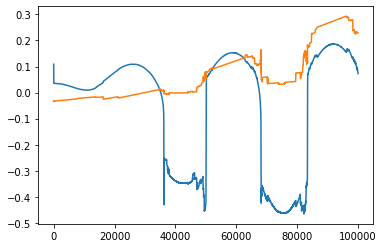

In [379]:
plt.plot(lrp.mean(axis=0)[:, 1])
plt.plot(lrp.mean(axis=0)[:, 2])

In [387]:
def plot_lrp_dominance_ensemble(forcing_type, model_type, xaxis, crop=64):
    """
    Plot SHAP-dominance scatter, excluding the first `crop` absolute indices,
    adjusted for model-dependent offset, with legend at the bottom.
    """
    # --- Data preparation ---
    input_data, output_data, qplot = get_data(forcing_type)
    lrp_mean = np.load(f'lrp_norm/lrp_{model_type}_{forcing_type}.npy').mean(axis=0)
    # --- Determine offset ---
    if model_type == "transformer" and forcing_type == "ns":
        offset = 63
    elif model_type == "lstm" and forcing_type == "ns":
        offset = 31
    elif model_type != "mlp" and forcing_type == "s":
        offset = 15
    else:
        offset = 0
    total_crop = crop
    crop_after_offset = max(0, total_crop - offset)
    input_data = input_data[offset:]
    qplot = qplot[offset:]
    # --- LRP filtering ---
    lrp_sal = lrp_mean[crop:, 1]
    lrp_temp = lrp_mean[crop:, 2]
    
    colors_filtered = np.where(lrp_temp > lrp_sal, '#ff7f0e', '#1f77b4')
    predicted = np.load(f'preds/{model_type}_{forcing_type}.npy')
    predicted_all = predicted.mean(axis=0)[crop:]
    # --- Plotting ---
    fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharex=True, sharey=True)
    if xaxis == "t":
        x_full = input_data[:, 0]
    else:
        x_full = input_data[:, 3] / Fs_to_m_per_year
    # --- Now all have same length after cropping ---
    x_plot = x_full[crop:]
    q_plot = qplot[crop:] / Sv
    # SHAP-dominance color plot
    # Plot orange first
    orange_mask = colors_filtered == '#ff7f0e'
    ax[0].scatter(x_plot[orange_mask], q_plot[orange_mask], c='#ff7f0e',
                  marker='o', s=18, alpha=0.3, rasterized=True)
    # Plot blue on top
    blue_mask = colors_filtered == '#1f77b4'
    ax[0].scatter(x_plot[blue_mask], q_plot[blue_mask], c='#1f77b4',
                  marker='o', s=18, alpha=0.3, rasterized=True)
    ax[0].plot(x_plot, q_plot, linestyle='--', color='grey')
    #ax[0].scatter(x_plot, q_plot, c=colors_filtered, marker='o', s=18, rasterized=True)
    #ax[0].plot(x_plot, q_plot, linestyle='--', color='grey')  # grey dotted line
    # Prediction
    sc = ax[1].scatter(x_plot, q_plot, c=predicted_all, cmap="plasma", s=10, vmin=0.0, vmax=1.0, rasterized=True)
    ax[1].plot(x_plot, q_plot, color="grey", linestyle="--")  # grey dashed line
    # --- Aesthetics ---
    fig.colorbar(sc, ax=ax[1], label="Prediction Confidence")
    for a in ax:
        a.axhline(0, color='black', linestyle='--')
        a.set_xlabel('Time (kyr)' if xaxis == "t" else '$F_S$ (m/yr)')
    ax[0].set_ylabel('AMOC (Sv)')
    # --- Legend at the bottom ---
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10),
        plt.Line2D([0], [0], color='grey', linestyle='--')
    ]
    fig.legend(legend_handles,
               ['$LRP (\Delta T)$', '$LRP (\Delta S)$', 'Circulation'],
               loc='lower center', bbox_to_anchor=(0.5, -0.05),
               ncol=3, frameon=False, fontsize='small')
    # --- Title ---
    fig.suptitle("Stationary forcing" if forcing_type == "s" else "Nonstationary forcing")
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    return fig

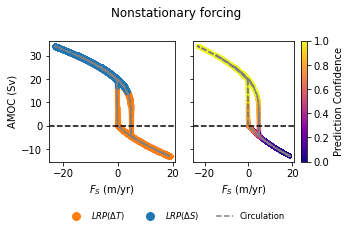

In [394]:
fig = plot_lrp_dominance_ensemble('ns', 'lstm', 'fwf')

In [395]:
fig.savefig('figures/lrp/pred_conf_lstm_ns.pdf', bbox_inches='tight')

In [37]:
def get_all_preds(forcing_type, model_type):
    
    # getting data
    input_data, output_data, qplot = get_data(forcing_type)
    X_train = input_data[0:60032]
    y_train = output_data[0:60032]
    X_val = input_data[61024:81000]
    y_val = output_data[61024:81000]
    X_test = input_data[81992:100000]
    y_test = output_data[81992:100000]
    
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    input_scaled = scaler.transform(input_data)
    
    oos_input = input_scaled[60033:]
    oos_output = output_data[60033:]

    
    models = get_models(forcing_type, model_type)
    
    predicted_results_ensemble = np.nan * np.zeros((12, input_scaled.shape[0], 1))
    
    if forcing_type == "s":
        time_steps = 16
    else:
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
        
    # Create sequences
    if model_type == "lstm":
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
        input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)
        oos_input_seq, oos_output_seq = create_sequences(oos_input, oos_output, time_steps)
        predicted_results_ensemble = np.nan * np.zeros((12, input_seq.shape[0], 1))
        
        for i in range(12):
            print(i)
            model_i = models[i]
            model_i.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            loss, accuracy= model_i.evaluate(oos_input_seq, oos_output_seq)
            print(f'Out of sample loss: {loss}')
            print(f'Out of sample accuracy: {accuracy}')
            predicted = model_i.predict(input_seq)
            predicted_results_ensemble[i,...] = predicted
            
        #return np.mean(predicted_results_ensemble, axis=0).reshape(-1), output_seq
        return predicted_results_ensemble, output_seq
    
    elif model_type == "transformer":
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
        input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)
        oos_input_seq, oos_output_seq = create_sequences(oos_input, oos_output, time_steps)
        predicted_results_ensemble = np.nan * np.zeros((12, input_seq.shape[0], 1))
        
        for i in range(12):
            print(i)
            model_i = models[i]
            model_i.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            loss, accuracy= model_i.evaluate(oos_input_seq, oos_output_seq)
            print(f'Out of sample loss: {loss}')
            print(f'Out of sample accuracy: {accuracy}')
            predicted = model_i.predict(input_seq)
            predicted_results_ensemble[i,...] = predicted
            
        #return np.mean(predicted_results_ensemble, axis=0).reshape(-1), output_seq
        return predicted_results_ensemble, output_seq
    
    
    for i in range(12):
        print(i)
        model_i = models[i]
        model_i.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        loss, accuracy= model_i.evaluate(oos_input, oos_output)
        print(f'Out of sample loss: {loss}')
        print(f'Out of sample accuracy: {accuracy}')
        predicted = model_i.predict(input_scaled)
        predicted_results_ensemble[i,...] = predicted
        
    
    #return predicted_results_ensemble.mean(axis=0).squeeze(), output_data
    return predicted_results_ensemble, output_data

In [38]:
def plot_lrp_over_amoc(forcing_type, model_type):
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    predicted_all = get_all_preds(forcing_type, model_type)
    end = len(input_data)
    
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
        
    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]

    fig, ax1 = plt.subplots(figsize=(8,4))
    fig.suptitle('Layer-wise Relevance Propagation for ' + str.upper(model_type) + ' ensemble')

    # Left y-axis (LRP values)
    ax1.scatter(input_data[:end, 0], lrp_sal_mean, alpha=0.5, s=8, color="tab:blue", label="Sal LRP")
    ax1.scatter(input_data[:end, 0], lrp_temp_mean, alpha=0.5, s=8, color="tab:orange", label="Temp LRP")
    ax1.set_xlabel("Freshwater Forcing")
    ax1.set_ylabel("LRP values")
    
    # Right y-axis (Q values)
    ax2 = ax1.twinx()
    ax2.plot(input_data[:end, 0], qplot[:end]/Sv, linestyle="--", color="grey", label="AMOC")
    ax2.set_ylabel("Q values")

    # Combine legends from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="best")

    plt.show()


In [40]:
def plot_lrp_over_amoc_combined(model_type):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
    forcing_types = ["s", "ns"]
    titles = ["Stationary forcing", "Nonstationary forcing"]

    # Collect legend handles manually
    legend_handles = []
    legend_labels = []

    for i, (ax, forcing_type, title) in enumerate(zip(axes, forcing_types, titles)):
        input_data, output_data, qplot = get_data(forcing_type)
        lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')

        # --- Compute LRP mean depending on model type ---
        if model_type == "lstm":
            shift = 15 if forcing_type == "s" else 31
            lrp_avg = lrp.mean(axis=(0, 2))
        else:
            shift = 0
            lrp_avg = lrp.mean(axis=0)

        total_crop = 64
        crop_after_shift = max(0, total_crop - shift)
        aligned_input = input_data[shift:][crop_after_shift:]
        aligned_qplot = qplot[shift:][crop_after_shift:]
        lrp_sal_mean = lrp_avg[crop_after_shift:, 1]
        lrp_temp_mean = lrp_avg[crop_after_shift:, 2]

        # --- Plot LRP curves ---
        line_sal, = ax.plot(
            aligned_input[:, 0], lrp_sal_mean,
            color="tab:blue", linewidth=2, label="LRP($\Delta S$)"
        )
        line_temp, = ax.plot(
            aligned_input[:, 0], lrp_temp_mean,
            color="tab:orange", linewidth=2, label="LRP($\Delta T$)"
        )
        ax.set_xlabel("Time (kyr)")
        ax.set_title(title)

        if i == 0:
            ax.set_ylabel("LRP values")

        # --- Plot AMOC (circulation) on twin axis ---
        ax_r = ax.twinx()
        line_circ, = ax_r.plot(
            aligned_input[:, 0],
            aligned_qplot / Sv,
            linewidth=4,
            color="grey",
            alpha=0.3,
            label="Circulation"
        )

        if i == 1:
            ax_r.set_ylabel("AMOC (Sv)", labelpad=8)
        else:
            ax_r.set_yticklabels([])

        # Store handles for legend (only once)
        if i == 0:
            legend_handles = [line_sal, line_temp, line_circ]
            legend_labels = [h.get_label() for h in legend_handles]

    # --- Combined legend ---
    fig.legend(
        legend_handles,
        legend_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=False
    )

    fig.tight_layout(rect=[0, 0.05, 1, 1])
    return fig


In [41]:
def plot_lrp_over_amoc(forcing_type, model_type):
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = 0

    if model_type == "lstm":
        if forcing_type == "s":
            end = 16-1
        else:
            end = 32 - 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)

    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]

    # Create two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 2), sharey=False, sharex=True)
    fig.suptitle("Time Evolution of Salinity and Temperature Relevance")

    # --- Left subplot: Salinity ---
    ax1 = axes[0]
    ax1.plot(input_data[end:, 0], lrp_sal_mean, color="tab:blue", label="LRP($\Delta S$)")
    ax1.plot(input_data[end:, 0], lrp_temp_mean, color="tab:orange", label="LRP($\Delta T$)")
    ax1.set_xlabel("Time (kyr)")
    ax1.set_ylabel("LRP values")

    ax1_r = ax1.twinx()
    ax1_r.plot(input_data[end:, 0], qplot[end:]/Sv, linewidth=5, color="grey", label="AMOC", alpha=0.5)

    # --- Right subplot: Temperature ---
    ax2 = axes[1]
    ax2.plot(input_data[end:, 0], lrp_temp_mean, color="tab:orange", label="LRP($\Delta T$)")
    ax2.set_xlabel("Time (kyr)")

    ax2_r = ax2.twinx()
    ax2_r.plot(input_data[end:, 0], qplot[end:]/Sv, linewidth=5, color="grey", label="AMOC", alpha=0.5)
    ax2_r.set_ylabel("AMOC (Sv)")

    # --- Collect legend handles from all axes ---
    handles, labels = [], []
    for ax in [ax1, ax1_r, ax2, ax2_r]:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l

    # Remove duplicates (since AMOC prediction appears twice)
    unique = dict(zip(labels, handles))

    # Place a single combined legend below the plots
    fig.legend(unique.values(), unique.keys(),
               loc="upper center", bbox_to_anchor=(0.5, -0.0001),
               ncol=3, frameon=False)

    fig.tight_layout(rect=[0, 0.05, 1, 1])
    #plt.legend()
    return fig


In [42]:
def plot_lrp_over_hysteresis(forcing_type, model_type):
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = 0

    if model_type == "lstm":
        if forcing_type == "s":
            end = 16-1
        else:
            end = 32 - 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)

    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]

    # Create two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 2), sharey=False, sharex=True)
    fig.suptitle("Salinity and Temperature Relevance with respect to Hysteresis")

    # --- Left subplot: Salinity ---
    ax1 = axes[0]
    ax1.plot(input_data[end:, 3]/Fs_to_m_per_year, lrp_sal_mean, color="tab:blue", label="LRP($\Delta S$)")
    ax1.set_xlabel("$F_S$ (m/yr)")
    ax1.set_ylabel("LRP values")

    ax1_r = ax1.twinx()
    ax1_r.plot(input_data[end:, 3]/Fs_to_m_per_year, qplot[end:]/Sv, linewidth=5, color="grey", label="AMOC prediction", alpha=0.5)

    # --- Right subplot: Temperature ---
    ax2 = axes[1]
    ax2.plot(input_data[end:, 3]/Fs_to_m_per_year, lrp_temp_mean, color="tab:orange", label="LRP($\Delta T$)")
    ax2.set_xlabel("$F_S$ (m/yr)")

    ax2_r = ax2.twinx()
    ax2_r.plot(input_data[end:, 3]/Fs_to_m_per_year, qplot[end:]/Sv, linewidth=5, color="grey", label="AMOC prediction", alpha=0.5)
    ax2_r.set_ylabel("AMOC (Sv)")

    # --- Collect legend handles from all axes ---
    handles, labels = [], []
    for ax in [ax1, ax1_r, ax2, ax2_r]:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l

    # Remove duplicates (since AMOC prediction appears twice)
    unique = dict(zip(labels, handles))

    # Place a single combined legend below the plots
    fig.legend(unique.values(), unique.keys(),
               loc="upper center", bbox_to_anchor=(0.5, -0.0001),
               ncol=3, frameon=False)

    fig.tight_layout()
    return fig


In [43]:
def plot_lrp_time_gradient(forcing_type, model_type, save_path=None):
    input_data, output_data, qplot = get_data(forcing_type)
    background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
    
    lrp_val = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    
    end = 0
    if model_type == "lstm":
        if forcing_type == "s":
            end = 15
        else:
            end = 31
        lrp_matrix = lrp_val.mean(axis=(0, 2))[:, 1:3].T
    else:
        lrp_matrix = lrp_val.mean(axis=0)[:, 1:3].T
            
    time = input_data[end:, 0]
    feature_names = ['$\Delta$ S', '$\Delta$ T']

    fig, ax = plt.subplots(2, 1, figsize=(6,3), constrained_layout=True, sharex=True)

    # --- Top: AMOC plot ---
    ax[0].plot(input_data[end:, 0], qplot[end:] / Sv, color='black', linewidth=2.5)  # thicker line
    #ax[0].axvline(x=time[60033], color='grey', linestyle='--')
    ax[0].set_ylabel('AMOC (Sv)')
    #ax[0].set_title(f"AMOC evolution ({model_type.upper()}, {forcing_type})")

    # --- Bottom: LRP heatmap ---
    sorted_idx_lrp = np.argsort(time)
    lrp_sorted = lrp_matrix[:, sorted_idx_lrp]
    vmin, vmax = np.percentile(lrp_sorted, [1, 99])
    X, Y = np.meshgrid(time[sorted_idx_lrp], np.arange(2))
    im_lrp = ax[1].pcolormesh(X, Y, lrp_sorted, shading='auto',
                              cmap='coolwarm', vmin=vmin, vmax=vmax, rasterized=True)
    ax[1].set_yticks(np.arange(len(feature_names)))
    ax[1].set_yticklabels(feature_names)
    ax[1].set_xlabel("Time (kyr)")
    cbar_lrp = fig.colorbar(im_lrp, ax=ax[1], pad=0.01)
    cbar_lrp.set_label("LRP Value")

    #fig.suptitle(f"AMOC and LRP evolution for {model_type.upper()} ensemble")
    fig.suptitle("Stationary forcing" if forcing_type == "s" else "Nonstationary forcing")
    

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    
    return fig


In [44]:
def plot_time_gradient(forcing_type, model_type, save_path=None):
    input_data, output_data, qplot = get_data(forcing_type)
    background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
    
    shap_val = np.load(f'shap_npy/shap_{model_type}_{forcing_type}.npy')
    lrp_val = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    
    shap_matrix = shap_val.squeeze().mean(axis=0)[:, 1:3].T
    lrp_matrix = lrp_val.mean(axis=0)[:, 1:3].T
    
    time = input_data[:, 0]
    
    feature_names = ['$\Delta$ Salinity', '$\Delta$ Temperature']

    fig, ax = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    
    # Top: LRP heatmap 
    sorted_idx_lrp = np.argsort(time)
    lrp_sorted = lrp_matrix[:, sorted_idx_lrp]
    vmin, vmax = np.percentile(lrp_sorted, [1, 99])
    X, Y = np.meshgrid(time[sorted_idx_lrp], np.arange(2))
    im_lrp = ax[0].pcolormesh(X, Y, lrp_sorted, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax[0].set_yticks(np.arange(len(feature_names)))
    ax[0].set_yticklabels(feature_names)
    cbar_lrp = fig.colorbar(im_lrp, ax=ax[0], pad=0.01)
    cbar_lrp.set_label("LRP Value")

    # Middle: AMOC scatter
    ax[1].set_ylabel('AMOC')
    ax[1].plot(time, qplot/Sv, color='black')
    ax[1].axvline(x=time[60033], color='grey', linestyle='--')

    # Bottom: SHAP heatmap
    sorted_idx = np.argsort(time[sample_indices])
    shap_sorted = shap_matrix[:, sorted_idx]
    vmin, vmax = np.percentile(shap_sorted, [1, 99])
    X, Y = np.meshgrid(time[sample_indices][sorted_idx], np.arange(2))
    im_shap = ax[2].pcolormesh(X, Y, shap_sorted, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax[2].set_xlabel("Time")
    ax[2].set_yticks(np.arange(len(feature_names)))
    ax[2].set_yticklabels(feature_names)
    cbar_shap = fig.colorbar(im_shap, ax=ax[2], pad=0.01)
    cbar_shap.set_label("SHAP Value")

    fig.suptitle('Time Evolution of SHAP and LRP for ' + str.upper(model_type) + ' Ensemble')

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    
    return fig


In [45]:
def plot_shap_time_gradient(forcing_type, model_type, save_path=None):
    input_data, output_data, qplot = get_data(forcing_type)
    background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
    
    shap_val = np.load(f'shap_npy/shap_{model_type}_{forcing_type}.npy')
    lrp_val = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    
    shap_matrix = shap_val.squeeze().mean(axis=0).T
    lrp_matrix = lrp_val.mean(axis=0).T
    
    time = input_data[:, 0]
    
    feature_names = ['Time', '$\Delta$ Salinity', '$\Delta$ Temperature', 'Freshwater Forcing']

    fig, ax = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    
    
    # Top: LRP heatmap 
    sorted_idx_lrp = np.argsort(time)
    lrp_sorted = lrp_matrix[:, sorted_idx_lrp]
    
    X, Y = np.meshgrid(time[sorted_idx_lrp],  np.arange(4))
    ax[0].pcolormesh(X, Y, lrp_sorted, shading='auto', cmap='coolwarm')  # shading='auto' avoids visual artifacts
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Features")
    
    # Middle: AMOC
    #ax[0].scatter(time[sample_indices], qplot[sample_indices]/1e10, color='black', s=10)
    ax[1].set_ylabel('AMOC')
    ax[1].scatter(time[sample_indices], shap_matrix[1, :], label='Sal SHAP', s=10)
    ax[1].scatter(time[sample_indices], shap_matrix[2, :], label='Temp SHAP', s=10)

    # Bottom: SHAP heatmap
    sorted_idx = np.argsort(time[sample_indices])
    shap_sorted = shap_matrix[:, sorted_idx]
    
    X, Y = np.meshgrid(time[sample_indices][sorted_idx],  np.arange(4))
    ax[2].pcolormesh(X, Y, shap_sorted, shading='auto', cmap='coolwarm')  # shading='auto' avoids visual artifacts
    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("Features")


    # Y-axis: categorical feature labels
    ax[2].set_yticks(np.arange(len(feature_names)))
    ax[2].set_yticklabels(feature_names)
    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("Features")


    # Colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("SHAP Value")
    
    fig.suptitle('Time Evolution of SHAP for ' + str.upper(model_type) + ' Ensemble')

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    
    plt.legend()
    return fig


In [46]:
def plot_shap_time(model_type):
    """
    Compare median SHAP(ΔT) and SHAP(ΔS) contributions over time 
    for stationary and nonstationary forcings, including AMOC overlay.
    
    - Always crops first 64 timesteps.
    - Then applies model-dependent offsets for alignment.
    - Two panels: left = stationary, right = nonstationary.
    """

    # --- Model-specific offsets after 64-crop ---
    def get_offset(model_type, forcing_type):
        if model_type == "transformer" and forcing_type == "ns":
            return 63
        elif model_type == "lstm" and forcing_type == "ns":
            return 33
        elif forcing_type == "s" and model_type != "mlp":
            return 15
        else:
            return 0

    fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True)
    forcing_types = ["s", "ns"]
    twin_axes = []  # to keep track of twin axes for legend

    for j, forcing_type in enumerate(forcing_types):
        # --- Load data ---
        input_sample, shap_sal_mean, shap_temp_mean, sample_indices = get_avg_shap_vals(forcing_type, model_type)
        input_data, output_data, qplot = get_data(forcing_type)

        # --- Apply global crop (always first 64 removed) ---
        crop = 64
        keep_mask = sample_indices >= crop
        sample_indices = sample_indices[keep_mask]
        shap_sal_mean = shap_sal_mean[keep_mask]
        shap_temp_mean = shap_temp_mean[keep_mask]

        # --- Apply model offset ---
        offset = get_offset(model_type, forcing_type)
        input_data = input_data[offset:]
        qplot = qplot[offset:]
        sample_indices = sample_indices[sample_indices < len(input_data)]  # avoid out-of-bounds

        # --- Extract relevant arrays ---
        time_vals = input_data[sample_indices, 0]
        qplot_crop = qplot[crop:] / Sv

        # --- Compute median binned SHAP values ---
        min_x, max_x = time_vals.min(), time_vals.max()
        spacing = (max_x - min_x) / 100
        valid_x, median_sal, median_temp = [], [], []
        for i in range(100):
            start_x = min_x + i * spacing
            end_x = start_x + spacing
            subset = np.where((time_vals >= start_x) & (time_vals < end_x))[0]
            if len(subset) == 0:
                continue
            valid_x.append((start_x + end_x) / 2)
            median_sal.append(np.median(shap_sal_mean[subset]))
            median_temp.append(np.median(shap_temp_mean[subset]))

        # --- Plot SHAP contributions ---
        ax = axes[j]
        ax.plot(valid_x, median_sal, linewidth=2, color='tab:blue', label='SHAP(ΔS)')
        ax.plot(valid_x, median_temp, linewidth=2, color='tab:orange', label='SHAP(ΔT)')
        ax.set_xlabel("Time (kyr)")
        if j == 0:
            ax.set_ylabel("SHAP values")
        ax.set_title("Stationary forcing" if forcing_type == "s" else "Nonstationary forcing")

        # --- Overlay AMOC ---
        ax_r = ax.twinx()
        ax_r.plot(input_data[crop:, 0], qplot_crop, linewidth=4, alpha=0.3, color='grey', label='Circulation')
        if j == 1:
            ax_r.set_ylabel("AMOC (Sv)")
        twin_axes.append(ax_r)

    # --- Combine legend from main and twin axes ---
    handles, labels = [], []
    for a in list(axes) + twin_axes:   # convert axes to list
        h, l = a.get_legend_handles_labels()
        handles += h
        labels += l
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(),
               loc="upper center", bbox_to_anchor=(0.5, -0.0001),
               ncol=3, frameon=False)


    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig


In [47]:
def plot_shap_time(forcing_type, model_type):
    input_sample, shap_sal_mean, shap_temp_mean, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)
    fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharex=True)

    # Left subplot
    #ax[0].scatter(input_data[sample_indices, 0], shap_sal_mean, 
    #              alpha=0.5, label='SHAP ($\Delta S$)', s=8, color='tab:blue')
    ax[0].set_xlabel('Time (kyr)')
    ax[0].set_ylabel('SHAP values')
    #ax[0].set_title('Median Salinity Contribution over Time')
    
    min_x, max_x = (input_data[sample_indices, 0]).min(), (input_data[sample_indices, 0]).max()

    mean_shap = []
    valid_x = []
    spacing = (max_x-min_x)/100
    for i in range(100):
        start_x = min_x + spacing * i
        end_x = start_x + spacing
        subset = np.where((input_data[sample_indices, 0] >= start_x) & (input_data[sample_indices, 0]<end_x))[0] 
        if len(subset) == 0:
            continue
        valid_x.append((start_x+end_x)/2)
        mean_shap.append(np.median(shap_sal_mean[subset]))
    ax[0].plot(valid_x, mean_shap, color='tab:blue')

    ax0 = ax[0].twinx()
    ax0.plot(input_data[:, 0], qplot/Sv, linestyle='--', 
             color='grey')

    # Combine legends for left subplot
#     lines, labels = ax[0].get_legend_handles_labels()
#     lines2, labels2 = ax0.get_legend_handles_labels()
#     ax[0].legend(lines + lines2, labels + labels2, loc='lower left')

    # Right subplot
    #ax[1].scatter(input_data[sample_indices, 0], shap_temp_mean, 
    #              alpha=0.5, label='SHAP ($\Delta T$)', s=8, color='tab:orange')
    ax[1].set_xlabel('Time (kyr)')
    
    
    min_x, max_x = (input_data[sample_indices, 0]).min(), (input_data[sample_indices, 0]).max()

    mean_shap = []
    valid_x = []
    spacing = (max_x-min_x)/100
    for i in range(100):
        start_x = min_x + spacing * i
        end_x = start_x + spacing
        subset = np.where((input_data[sample_indices, 0] >= start_x) & (input_data[sample_indices, 0]<end_x))[0] 
        if len(subset) == 0:
            continue
        valid_x.append((start_x+end_x)/2)
        mean_shap.append(np.median(shap_temp_mean[subset]))
    ax[1].plot(valid_x, mean_shap, color='tab:orange')
    #ax[1].set_title('Median Temperature Contribution over Time')
    
    fig.suptitle('Median $\Delta S$ and $\Delta T$ Contribution over Time')
    
    ax1 = ax[1].twinx()
    ax1.plot(input_data[:, 0], qplot/Sv, linestyle='--', 
             color='grey', label='Circulation')
    ax1.set_ylabel('AMOC (Sv)')
   
    # --- Collect legend handles from all axes ---
    handles, labels = [], []
    for ax in [ax1, ax1_r, ax2, ax2_r]:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l

    # Remove duplicates (since AMOC prediction appears twice)
    unique = dict(zip(labels, handles))

    # Place a single combined legend below the plots
    fig.legend(unique.values(), unique.keys(),
               loc="upper center", bbox_to_anchor=(0.5, -0.0001),
               ncol=3, frameon=False)

    fig.tight_layout(rect=[0, 0.05, 1, 1])

    
    # Combine legends for right subplot
    #lines, labels = ax[1].get_legend_handles_labels()
    #lines2, labels2 = ax1.get_legend_handles_labels()
    #ax[1].legend(lines + lines2, labels + labels2, loc='lower left')
    plt.tight_layout()
    return fig

In [48]:
def plot_shap_time(forcing_type, model_type):
    input_sample, shap_sal_mean, shap_temp_mean, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)
    fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharex=True)

    # Left subplot (Salinity)
    ax[0].set_xlabel('Time (kyr)')
    ax[0].set_ylabel('SHAP values')
    min_x, max_x = input_data[sample_indices, 0].min(), input_data[sample_indices, 0].max()
    mean_shap, valid_x = [], []
    spacing = (max_x - min_x) / 100
    for i in range(100):
        start_x = min_x + spacing * i
        end_x = start_x + spacing
        subset = np.where((input_data[sample_indices, 0] >= start_x) & 
                          (input_data[sample_indices, 0] < end_x))[0] 
        if len(subset) == 0:
            continue
        valid_x.append((start_x + end_x)/2)
        mean_shap.append(np.median(shap_sal_mean[subset]))
    ax[0].plot(valid_x, mean_shap, color='tab:blue', label='SHAP ($\Delta S$)')

    ax0 = ax[0].twinx()
    ax0.plot(input_data[:, 0], qplot/Sv, linestyle='--', color='grey', label='AMOC prediction')

    # Right subplot (Temperature)
    ax[1].set_xlabel('Time (kyr)')
    mean_shap, valid_x = [], []
    for i in range(100):
        start_x = min_x + spacing * i
        end_x = start_x + spacing
        subset = np.where((input_data[sample_indices, 0] >= start_x) & 
                          (input_data[sample_indices, 0] < end_x))[0] 
        if len(subset) == 0:
            continue
        valid_x.append((start_x + end_x)/2)
        mean_shap.append(np.median(shap_temp_mean[subset]))
    ax[1].plot(valid_x, mean_shap, color='tab:orange', label='SHAP ($\Delta T$)')

    ax1 = ax[1].twinx()
    ax1.plot(input_data[:, 0], qplot/Sv, linestyle='--', color='grey', label='AMOC prediction')
    ax1.set_ylabel('AMOC (Sv)')

    # --- Combined legend ---
    handles, labels = [], []
    for a in [ax[0], ax0, ax[1], ax1]:
        h, l = a.get_legend_handles_labels()
        handles += h
        labels += l
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(),
               loc="upper center", bbox_to_anchor=(0.5, -0.001),
               ncol=3, frameon=False)

    fig.suptitle('Median $\Delta S$ and $\Delta T$ Contribution over Time')
    fig.tight_layout(rect=[0, 0.05, 1, 1])

    return fig


In [49]:
def plot_shap_hysteresis(forcing_type, model_type, n_bins=100):
    input_sample, shap_sal_mean, shap_temp_mean, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

    # Extract time and Fs for sampled points
    time_vals = input_data[sample_indices, 0]
    Fs_vals = input_data[sample_indices, 3] / Fs_to_m_per_year

    # ---------------------------
    # Left subplot: SHAP ΔS
    # ---------------------------
    ax[0].set_xlabel('Freshwater forcing (m/yr)')
    ax[0].set_ylabel('SHAP values')

    min_time, max_time = time_vals.min(), time_vals.max()
    spacing = (max_time - min_time) / n_bins
    mean_shap_sal = []
    Fs_bin = []

    for i in range(n_bins):
        start_t = min_time + i * spacing
        end_t = start_t + spacing
        subset = np.where((time_vals >= start_t) & (time_vals < end_t))[0]
        if len(subset) == 0:
            continue
        Fs_bin.append(Fs_vals[subset].mean())  # plot against mean Fs in the bin
        mean_shap_sal.append(np.median(shap_sal_mean[subset]))

    ax[0].plot(Fs_bin, mean_shap_sal, color='tab:blue', label='SHAP ΔS')

    # AMOC overlay vs Fs
    ax0 = ax[0].twinx()
    ax0.plot(input_data[:, 3] / Fs_to_m_per_year, qplot / Sv, linestyle='--', color='grey')
    #ax0.set_ylabel('AMOC (Sv)')

    # ---------------------------
    # Right subplot: SHAP ΔT
    # ---------------------------
    ax[1].set_xlabel('Freshwater forcing (m/yr)')

    mean_shap_temp = []
    Fs_bin_temp = []

    for i in range(n_bins):
        start_t = min_time + i * spacing
        end_t = start_t + spacing
        subset = np.where((time_vals >= start_t) & (time_vals < end_t))[0]
        if len(subset) == 0:
            continue
        Fs_bin_temp.append(Fs_vals[subset].mean())
        mean_shap_temp.append(np.median(shap_temp_mean[subset]))

    ax[1].plot(Fs_bin_temp, mean_shap_temp, color='tab:orange', label='SHAP ΔT')

    # AMOC overlay vs Fs
    ax1 = ax[1].twinx()
    ax1.plot(input_data[:, 3] / Fs_to_m_per_year, qplot / Sv, linestyle='--', color='grey')
    ax1.set_ylabel('AMOC (Sv)')

    fig.suptitle('Median $\Delta S$ and $\Delta T$ Contribution with respect to Hysteresis')
    fig.tight_layout()
    
    return fig


In [50]:
def plot_shap_fwf_gradient(forcing_type, model_type, save_path=None):
    input_data, output_data, qplot = get_data(forcing_type)
    background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
    shap_val = np.load(f'shap_npy/shap_{model_type}_{forcing_type}.npy')
    
    shap_matrix = shap_val.squeeze().mean(axis=0).T
    fwf = input_data[:, 3]
    feature_names = ['Time', '$\Delta$ Salinity', '$\Delta$ Temperature', 'Freshwater Forcing']

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True, dpi=200, sharex=True)

    # Top: AMOC
    #ax[0].scatter(fwf[sample_indices], qplot[sample_indices]/1e10, color='black')
    ax[0].set_ylabel('AMOC')
    ax[0].scatter(fwf[sample_indices], shap_matrix[1, :], label='Sal SHAP')
    ax[0].scatter(fwf[sample_indices], shap_matrix[2, :], label='Temp SHAP')

    # Bottom: SHAP heatmap
    sorted_idx = np.argsort(fwf[sample_indices])
    shap_sorted = shap_matrix[:, sorted_idx]
    
    X, Y = np.meshgrid(fwf[sample_indices][sorted_idx],  np.arange(4))
    ax[1].pcolormesh(X, Y, shap_sorted, shading='auto', cmap='coolwarm')  # shading='auto' avoids visual artifacts
    ax[1].set_xlabel("FWF")
    ax[1].set_ylabel("Features")


    # Y-axis: categorical feature labels
    ax[1].set_yticks(np.arange(len(feature_names)))
    ax[1].set_yticklabels(feature_names)
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Features")


    # Colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("SHAP Value")
    
    fig.suptitle('FWF Evolution of SHAP for ' + str.upper(model_type) + ' Ensemble')

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    
    return fig


In [51]:
def get_region_avg_shap(forcing_type, model_type):
    _, shap_ensemble, _, sample_indices = get_ensemble_shap_vals(forcing_type, model_type)
    mask_on, mask_off, mask_tipping = get_masks(forcing_type)
    indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]
    all_member_counts = []
    for i in range(12):
        sal_shap = shap_ensemble[i, :, 1]  # salinity
        temp_shap = shap_ensemble[i, :, 2]  # temperature

        # Boolean masks for each region
        mask_tipping = np.isin(sample_indices, indices_tipping)
        mask_on = np.isin(sample_indices, indices_on)
        mask_off = np.isin(sample_indices, indices_off)
        
        curr_counts= {'on_sal': sal_shap[mask_on].mean(), 
                      'off_sal': sal_shap[mask_off].mean(), 
                      'tipping_sal': sal_shap[mask_tipping].mean(),
                      'on_temp': temp_shap[mask_on].mean(),
                      'off_temp': temp_shap[mask_off].mean(),
                      'tipping_temp': temp_shap[mask_tipping].mean()
                     }
        all_member_counts.append(curr_counts)
    return all_member_counts

In [52]:
def get_region_avg_dominance(forcing_type, model_type):
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    mask_on, mask_off, mask_tipping = get_masks(forcing_type)
    tp1 = np.where((input_data[:, 0] > 7) & (input_data[:, 0] < 9))[0]
    tp2 = np.where((input_data[:, 0] > 30.5) & (input_data[:, 0] < 32.5))[0]
    tp3 = np.where((input_data[:, 0] > 43) & (input_data[:, 0] < 45))[0]
    tp4 = np.where((input_data[:, 0] > 55) & (input_data[:, 0] < 57))[0]
    tp5 = np.where((input_data[:, 0] > 68) & (input_data[:, 0] < 70))[0]
    stable_points_ns = np.hstack([tp1, tp2, tp3, tp4, tp5])
    stable_points_set = set(stable_points_ns)
    
    if model_type == "lstm":
        lrp = lrp[:, :, -1, :]
        if forcing_type == "s":
            mask_on = mask_on[15:]
            mask_off = mask_off[15:]
            mask_tipping = mask_tipping[15:]
            indices_on, indices_off, indices_tipping = np.arange(0, 100000-15, 1)[mask_on], np.arange(0, 100000-15, 1)[mask_off], np.arange(0, 100000-15, 1)[mask_tipping]
        else:
            mask_on = mask_on[31:]
            mask_off = mask_off[31:]
            mask_tipping = mask_tipping[31:]
            indices_on, indices_off, indices_tipping = np.arange(0, 100000-31, 1)[mask_on], np.arange(0, 100000-31, 1)[mask_off], np.arange(0, 100000-31, 1)[mask_tipping]
    else:
        indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]
    all_member_counts = []
    indices_on = np.array([idx for idx in indices_on if idx in stable_points_set])
    indices_off = np.array([idx for idx in indices_off if idx in stable_points_set])
    
#     lrp_norm_all = np.zeros_like(lrp, dtype=float)
#     for feature in range(lrp.shape[2]):
#         feature_data = lrp[:, :, feature]
#         feature_min = feature_data.min()
#         feature_max = feature_data.max()
#         lrp_norm_all[:, :, feature] = (feature_data - feature_min) / (feature_max - feature_min)
    
#     features_12 = lrp[:, :, [1, 2]]  # shape: (12, 100000, 2)
#     features_min = features_12.min()
#     features_max = features_12.max()
#     lrp_norm_12 = (features_12 - features_min) / (features_max - features_min)
        
    lrp_max = lrp.max()
    lrp_min = lrp.min()
    for i in range(12):
        lrp_i = lrp[i, :, :]
        #lrp_min = lrp_i.min()
        #lrp_max = lrp_i.max()
        lrp_i = (lrp_i - lrp_min) / (lrp_max - lrp_min)

        lrp_sal = lrp_i[:, 1]
        lrp_temp = lrp_i[:, 2]
        
        curr_counts= {'on_sal': np.median(lrp_sal[indices_on]), 
              'off_sal': np.median(lrp_sal[indices_off]), 
              'tipping_sal': np.median(lrp_sal[indices_tipping]),
              'on_temp': np.median(lrp_temp[indices_on]),
              'off_temp': np.median(lrp_temp[indices_off]),
              'tipping_temp': np.median(lrp_temp[indices_tipping])
             }
        all_member_counts.append(curr_counts)
    return all_member_counts

In [53]:
def get_lrp_regions(forcing_type, model_type):
    lrp_ensemble = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    
    if model_type == 'lstm':
        lrp_data = lrp_ensemble[:, :, -1, :]
    else:
        lrp_data = lrp_ensemble[:, :, :]
    
    # Method 2: Normalize each feature globally by its max absolute value
#     lrp_ensemble_v2 = np.zeros_like(lrp_data, dtype=float)
#     for feature in range(lrp_data.shape[2]):
#         feature_data = lrp_data[:, :, feature]
#         max_abs = np.abs(feature_data).max()
#         lrp_ensemble_v2[:, :, feature] = feature_data / (max_abs + 1e-8)
    
#     lrp_ensemble = lrp_ensemble_v2
    lrp_max = lrp_data.max()
    lrp_min = lrp_data.min()
    
    all_members_counts = []
    mask_on, mask_off, mask_tipping = get_masks(forcing_type)
    
    if model_type == "lstm":
        if forcing_type == "s":
            mask_on = mask_on[15:]
            mask_off = mask_off[15:]
            mask_tipping = mask_tipping[15:]
            indices_on, indices_off, indices_tipping = np.arange(0, 100000-15, 1)[mask_on], np.arange(0, 100000-15, 1)[mask_off], np.arange(0, 100000-15, 1)[mask_tipping]
        else:
            mask_on = mask_on[31:]
            mask_off = mask_off[31:]
            mask_tipping = mask_tipping[31:]
            indices_on, indices_off, indices_tipping = np.arange(0, 100000-31, 1)[mask_on], np.arange(0, 100000-31, 1)[mask_off], np.arange(0, 100000-31, 1)[mask_tipping]
    else:
        indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]
    
    # Filter On/Off to only include stable points (for nonstationary forcing)
    tp1 = np.where((input_data[:, 0] > 7) & (input_data[:, 0] < 9))[0]
    tp2 = np.where((input_data[:, 0] > 30.5) & (input_data[:, 0] < 32.5))[0]
    tp3 = np.where((input_data[:, 0] > 43) & (input_data[:, 0] < 45))[0]
    tp4 = np.where((input_data[:, 0] > 55) & (input_data[:, 0] < 57))[0]
    tp5 = np.where((input_data[:, 0] > 68) & (input_data[:, 0] < 70))[0]
    stable_points_ns = np.hstack([tp1, tp2, tp3, tp4, tp5])
#     if forcing_type == 'ns':
#         input_data, _, qplot = get_data('ns')
#         stable_on = np.where(qplot/Sv > 27)[0]
#         stable_off = np.where(qplot/Sv < -8)[0]
#         stable_points_ns = np.hstack([stable_on, stable_off])
    stable_points_set = set(stable_points_ns)
    indices_on = np.array([idx for idx in indices_on if idx in stable_points_set])
    indices_off = np.array([idx for idx in indices_off if idx in stable_points_set])
    # Tipping remains the same
    print('on:', len(indices_on))
    print('off:', len(indices_off))
    for i in range(12):
        lrp_norm = (lrp_data[i, :, :] - lrp_min) / (lrp_max - lrp_min)
        sal_lrp = lrp_norm[:, 1]  # salinity
        temp_lrp = lrp_norm[:, 2]  # temperature
        
        # Count sal/temp dominance per region
        tipping_sal = np.sum(sal_lrp[indices_tipping] > temp_lrp[indices_tipping])
        tipping_temp = np.sum(sal_lrp[indices_tipping] <= temp_lrp[indices_tipping])
        on_sal = np.sum(sal_lrp[indices_on] > temp_lrp[indices_on])
        on_temp = np.sum(sal_lrp[indices_on] <= temp_lrp[indices_on])
        off_sal = np.sum(sal_lrp[indices_off] > temp_lrp[indices_off])
        off_temp = np.sum(sal_lrp[indices_off] <= temp_lrp[indices_off])
        
        # Compute percentages safely (avoid division by zero)
        def percent(n, total):
            return 100 * n / total if total > 0 else np.nan
        
        lrp_counts = {
            "tipping": {
                "sal": tipping_sal, "sal_pct": percent(tipping_sal, tipping_sal + tipping_temp),
                "temp": tipping_temp, "temp_pct": percent(tipping_temp, tipping_sal + tipping_temp)
            },
            "on": {
                "sal": on_sal, "sal_pct": percent(on_sal, on_sal + on_temp),
                "temp": on_temp, "temp_pct": percent(on_temp, on_sal + on_temp)
            },
            "off": {
                "sal": off_sal, "sal_pct": percent(off_sal, off_sal + off_temp),
                "temp": off_temp, "temp_pct": percent(off_temp, off_sal + off_temp)
            }
        }
        
        all_members_counts.append(lrp_counts)
    
    return all_members_counts

In [54]:
def plot_salinity_dominance_swarm(forcing_type, model_type):
    """
    Plots salinity dominance across ensemble members for a given model and forcing type.
    Y-axis is labeled with Temperature Dominant (0%), Balanced (50%), Salinity Dominant (100%).
    """
    # Get ensemble data
    member_counts = get_lrp_regions(forcing_type, model_type)
    avg_counts = get_region_avg_dominance(forcing_type, model_type)
    #member_counts = get_shap_regions(forcing_type, model_type)

    # Extract salinity percentages
    on_sal = np.array([m['on']['sal_pct'] for m in member_counts])
    off_sal = np.array([m['off']['sal_pct'] for m in member_counts])
    tipping_sal = np.array([m['tipping']['sal_pct'] for m in member_counts])

    # Combine into long-format DataFrame
    df = pd.DataFrame({
        "Regime": ["On"] * len(on_sal) + ["Off"] * len(off_sal) + ["Tipping"] * len(tipping_sal),
        "Salinity Dominance (%)": np.concatenate([on_sal, off_sal, tipping_sal])
    })

    # Create plot
    fig, ax = plt.subplots(figsize=(3, 2))
    
    sns.stripplot(
        data=df,
        x="Regime",
        y="Salinity Dominance (%)",
        alpha=0.5,
        color='green',           # face color
        edgecolor='black',       # edge color
        linewidth=0.8,
        size=10,
        jitter=0.05,  # small vertical jitter so 0/100 are visible
        ax=ax
    )
    
    plt.xlabel('')
    plt.ylabel('')

    # Add vertical separators
    x_positions = np.arange(len(df["Regime"].unique()) - 1) + 0.5
    for x in x_positions:
        plt.axvline(x=x, color="gray", linestyle="--", linewidth=1, alpha=0.6)

    # Horizontal line at 50% for balance
    plt.axhline(50, color="black", linestyle=":", linewidth=1, alpha=0.7)

    # Y-axis settings
    plt.ylim(-5, 105)  # small padding so points at 0 and 100% are visible

    # Custom y-ticks with descriptive labels
    plt.yticks([0, 50, 100], ["100% Temperature\n Dominant", "Balanced\n 50% Both", "100% Salinity\n Dominant"])

    #fig.suptitle(str.upper(model_type) + ' (' + str.upper(forcing_type) + ')')
    plt.tight_layout()
    
    return fig

In [55]:
def plot_salinity_dominance_swarm_w_avg(forcing_type, model_type):
    """
    Plots salinity dominance across ensemble members for a given model and forcing type.
    Left Y-axis: Temperature Dominant (0%), Balanced (50%), Salinity Dominant (100%) - green swarm
    Right Y-axis: Average dominance values (0-1) - blue (salinity) and orange (temperature) swarms
    """
    # Get ensemble data
    #member_counts = get_lrp_regions(forcing_type, model_type)
    member_counts = get_shap_regions(forcing_type, model_type)
    #avg_counts = get_region_avg_dominance(forcing_type, model_type)
    avg_counts = get_region_avg_shap(forcing_type, model_type)
    
    # Extract salinity percentages from ensemble members
    on_sal = np.array([m['on']['sal_pct'] for m in member_counts])
    off_sal = np.array([m['off']['sal_pct'] for m in member_counts])
    tipping_sal = np.array([m['tipping']['sal_pct'] for m in member_counts])
    
    # Combine into long-format DataFrame
    df = pd.DataFrame({
        "Regime": ["On"] * len(on_sal) + ["Off"] * len(off_sal) + ["Tipping"] * len(tipping_sal),
        "Salinity Dominance (%)": np.concatenate([on_sal, off_sal, tipping_sal])
    })
    
    # Create plot with secondary y-axis
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()
    
    # Left axis: green swarm plot
    sns.stripplot(
        data=df,
        x="Regime",
        y="Salinity Dominance (%)",
        alpha=0.5,
        color='green',
        edgecolor='black',
        linewidth=0.8,
        size=10,
        jitter=0.15,
        ax=ax
    )
    
    # Right axis: blue swarm plot for avg_counts (sal)
    avg_on_sal = np.array([m['on_sal'] for m in avg_counts])
    avg_off_sal = np.array([m['off_sal'] for m in avg_counts])
    avg_tipping_sal = np.array([m['tipping_sal'] for m in avg_counts])
    
    avg_df_sal = pd.DataFrame({
        "Regime": ["On"] * len(avg_on_sal) + ["Off"] * len(avg_off_sal) + ["Tipping"] * len(avg_tipping_sal),
        "Avg Salinity": np.concatenate([avg_on_sal, avg_off_sal, avg_tipping_sal])
    })
    
    sns.stripplot(
        data=avg_df_sal,
        x="Regime",
        y="Avg Salinity",
        alpha=0.5,
        color='tab:blue',
        edgecolor='black',
        linewidth=0.8,
        size=8,
        jitter=0.15,
        ax=ax2
    )
    
    # Right axis: orange swarm plot for avg_counts (temp)
    avg_on_temp = np.array([m['on_temp'] for m in avg_counts])
    avg_off_temp = np.array([m['off_temp'] for m in avg_counts])
    avg_tipping_temp = np.array([m['tipping_temp'] for m in avg_counts])
    
    avg_df_temp = pd.DataFrame({
        "Regime": ["On"] * len(avg_on_temp) + ["Off"] * len(avg_off_temp) + ["Tipping"] * len(avg_tipping_temp),
        "Avg Temperature": np.concatenate([avg_on_temp, avg_off_temp, avg_tipping_temp])
    })
    
    sns.stripplot(
        data=avg_df_temp,
        x="Regime",
        y="Avg Temperature",
        alpha=0.5,
        color='tab:orange',
        edgecolor='black',
        linewidth=0.8,
        size=8,
        jitter=0.15,
        ax=ax2
    )
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax2.set_ylabel('SHAP values')
    
    # Add vertical separators
    x_positions = np.arange(len(df["Regime"].unique()) - 1) + 0.5
    for x in x_positions:
        ax.axvline(x=x, color="gray", linestyle="--", linewidth=1, alpha=0.6)
    
    # Horizontal line at 50% for balance (left axis)
    ax.axhline(50, color="black", linestyle=":", linewidth=1, alpha=0.7)
    
    # Left Y-axis settings
    ax.set_ylim(-5, 105)
    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels(["100% Temperature\n Dominant", "Balanced\n 50% Both", "100% Salinity\n Dominant"])
    ax.spines['left'].set_visible(True)
    
    # Right Y-axis settings
    #ax2.set_ylim(-0.05, 1.05)
    #ax2.set_yticks([0, 0.5, 1.0])
    #ax2.spines['right'].set_visible(True)
    
    # Create manual legend with single entries
    from matplotlib.lines import Line2D
    legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, markeredgecolor='black', markeredgewidth=0.8, alpha=0.5, label='% Dom.'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=8, markeredgecolor='black', markeredgewidth=0.8, alpha=0.5, label='SHAP(ΔS)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', markersize=8, markeredgecolor='black', markeredgewidth=0.8, alpha=0.5, label='SHAP(ΔT)')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=8, handletextpad=0.1)
    
    plt.tight_layout()
    
    return fig

On: 56733, Off: 42090, Tipping: 1177
On: 56733, Off: 42090, Tipping: 1177
On: 56733, Off: 42090, Tipping: 1177
On: 56733, Off: 42090, Tipping: 1177
On: 56733, Off: 42090, Tipping: 1177
On: 56733, Off: 42090, Tipping: 1177
On: 70274, Off: 28743, Tipping: 983
On: 70274, Off: 28743, Tipping: 983
On: 70274, Off: 28743, Tipping: 983
On: 70274, Off: 28743, Tipping: 983
On: 70274, Off: 28743, Tipping: 983
On: 70274, Off: 28743, Tipping: 983


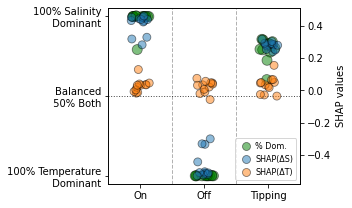

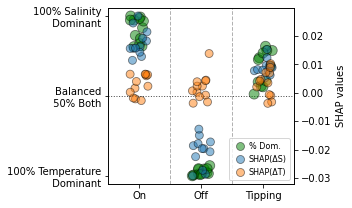

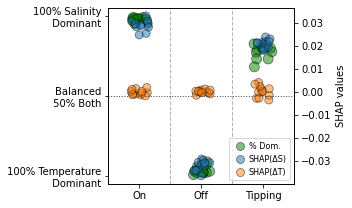

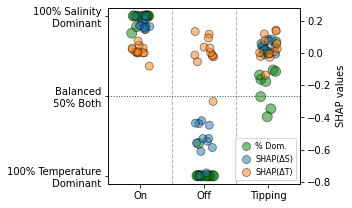

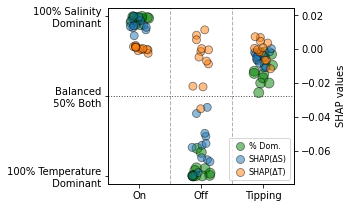

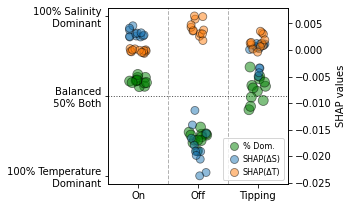

In [669]:
for ft in ['s', 'ns']:
    for mt in ['mlp', 'lstm', 'transformer']:
        fig = plot_salinity_dominance_swarm_w_avg(ft, mt)
        fig.savefig(f'figures/shap/shap_swarm_{mt}_{ft}_avg.pdf')

In [255]:
on, off, tipping = 0, 0, 0
for mc in member_counts:
    if mc['on_sal'] > mc['on_temp']:
        on += 1
    if mc['off_sal'] > mc['off_temp']:
        off += 1
    if mc['tipping_sal'] > mc['tipping_temp']:
        tipping += 1

In [567]:
def plot_feature_dominance_swarm(forcing_type, model_type):
    """
    Plots clustering of salinity vs temperature LRP values across ensemble members.
    Shows which feature dominates in each region.
    """
    # Get ensemble data
    member_counts = get_region_avg_dominance(forcing_type, model_type)
    #member_counts = get_region_avg_shap(forcing_type, model_type)
    
    # Extract values for each region
    regions_data = []
    for region in ['on', 'off', 'tipping']:
        sal_values = np.array([m[f'{region}_sal'] for m in member_counts])
        temp_values = np.array([m[f'{region}_temp'] for m in member_counts])
        
        for sal, temp in zip(sal_values, temp_values):
            regions_data.append({
                'Region': region.capitalize(),
                'Salinity': sal,
                'Temperature': temp
            })
    
    df = pd.DataFrame(regions_data)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(5, 3))
    
    for region in ['On', 'Off', 'Tipping']:
        region_df = df[df['Region'] == region]
        ax.scatter(region_df['Salinity'], region_df['Temperature'], 
                  label=region, alpha=0.6, s=100, edgecolor='black', linewidth=0.8)
    
    # Add diagonal line respecting actual data range
    min_val = min(df['Salinity'].min(), df['Temperature'].min())
    max_val = max(df['Salinity'].max(), df['Temperature'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Salinity SHAP', fontsize=12)
    ax.set_ylabel('Temperature SHAP', fontsize=12)
    ax.set_title(str.upper(model_type) + ' (' + str.upper(forcing_type) + ')')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

On: 56733, Off: 42090, Tipping: 1177
on: 5333
off: 7999


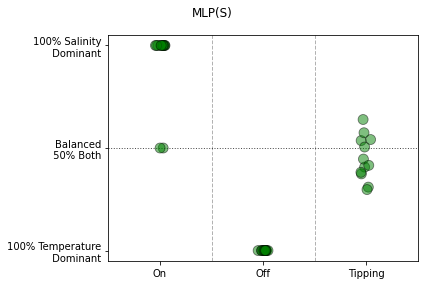

In [595]:
fig = plot_salinity_dominance_swarm("s", "mlp")

In [61]:
mask_on, mask_off, mask_tipping = get_masks("s")

On: 56733, Off: 42090, Tipping: 1177


In [78]:
indices_on, indices_off, indices_tipping = np.arange(0, 100000, 1)[mask_on], np.arange(0, 100000, 1)[mask_off], np.arange(0, 100000, 1)[mask_tipping]

In [83]:
lrp = np.load('lrp_npy/lrp_mlp_s.npy')

In [86]:
lrp[0, :, :].shape

(100000, 4)

In [66]:
lrp = np.load('lrp_npy/lrp_mlp_s.npy')
lrp = lrp.mean(axis=0)
lrp_min = lrp.min()
lrp_max = lrp.max()
lrp_norm = (lrp - lrp_min) / (lrp_max - lrp_min)

lrp_sal = lrp_norm[:, 1]
lrp_temp = lrp_norm[:, 2]

In [72]:
lrp_sal[mask_on].mean()

0.8873756767660582

In [73]:
lrp_temp[mask_on].mean()

0.5467854348830142

In [74]:
lrp_sal[mask_off].mean()

0.36582808032022995

In [75]:
lrp_temp[mask_off].mean()

0.4749996171180224

In [76]:
lrp_sal[mask_tipping].mean()

0.43941849271763306

In [77]:
lrp_temp[mask_tipping].mean()

0.48514574625144746

In [62]:
member_counts = get_shap_regions("s", "mlp")

On: 56733, Off: 42090, Tipping: 1177


In [64]:
on_sal = np.array([m['on']['sal_pct'] for m in member_counts])
off_sal = np.array([m['off']['sal_pct'] for m in member_counts])
tipping_sal = np.array([m['tipping']['sal_pct'] for m in member_counts])

In [66]:
on_sal.mean()

98.00955414012738

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_salinity_dominance_swarm(forcing_type, model_type):
    """
    Plots salinity dominance across ensemble members for a given model and forcing type.
    Y-axis is labeled with Temperature Dominant (0%), Balanced (50%), Salinity Dominant (100%).
    """
    # Get ensemble data
    member_counts = get_lrp_regions(forcing_type, model_type)
    #member_counts = get_shap_regions(forcing_type, model_type)

    # Extract salinity percentages
    on_sal = np.array([m['on']['sal_pct'] for m in member_counts])
    off_sal = np.array([m['off']['sal_pct'] for m in member_counts])
    tipping_sal = np.array([m['tipping']['sal_pct'] for m in member_counts])

    # Combine into long-format DataFrame
    df = pd.DataFrame({
        "Regime": ["On"] * len(on_sal) + ["Off"] * len(off_sal) + ["Tipping"] * len(tipping_sal),
        "Salinity Dominance (%)": np.concatenate([on_sal, off_sal, tipping_sal])
    })
    
    df_ens = pd.DataFrame({
        "Regime": ["On"] + ["Off"] + ["Tipping"],
        "Salinity Dominance (%)": [on_sal.mean(), off_sal.mean(), tipping_sal.mean()]
    })

    # Create plot
    fig, ax = plt.subplots(figsize=(4, 2.5))
    
    sns.stripplot(
        data=df,
        x="Regime",
        y="Salinity Dominance (%)",
        alpha=0.5,
        color='green',           # face color
        edgecolor='black',       # edge color
        linewidth=0.8,
        size=10,
        jitter=0.05,  # small vertical jitter so 0/100 are visible
        ax=ax
    )
    
    sns.stripplot(
        data=df_ens,
        x="Regime",
        y="Salinity Dominance (%)",
        alpha=0.5,
        color='red',           # face color
        edgecolor='black',       # edge color
        linewidth=0.8,
        size=10,
        jitter=1,  # small vertical jitter so 0/100 are visible
        ax=ax
    )
    
    plt.xlabel('')
    plt.ylabel('')

    # Add vertical separators
    x_positions = np.arange(len(df["Regime"].unique()) - 1) + 0.5
    for x in x_positions:
        plt.axvline(x=x, color="gray", linestyle="--", linewidth=1, alpha=0.6)

    # Horizontal line at 50% for balance
    plt.axhline(50, color="black", linestyle=":", linewidth=1, alpha=0.7)

    # Y-axis settings
    plt.ylim(-5, 105)  # small padding so points at 0 and 100% are visible

    # Custom y-ticks with descriptive labels
    plt.yticks([0, 50, 100], ["100% Temperature\n Dominant", "Balanced\n 50% Both", "100% Salinity\n Dominant"])
    
    from matplotlib.lines import Line2D
    legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
           markersize=8, markeredgecolor='black', markeredgewidth=0.8, alpha=0.5, label='Ind. %'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=8, markeredgecolor='black', markeredgewidth=0.8, alpha=0.5, label='Avg. %')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, handletextpad=0.01)

    plt.tight_layout()
    return fig


On: 56733, Off: 42090, Tipping: 1177
on: 5333
off: 7999


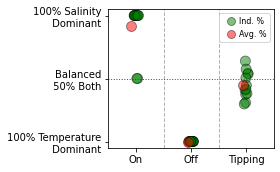

In [106]:
fig = plot_salinity_dominance_swarm('s', 'mlp')

On: 56733, Off: 42090, Tipping: 1177
on: 5333
off: 7999
On: 70274, Off: 28743, Tipping: 983
on: 7999
off: 5277
On: 56733, Off: 42090, Tipping: 1177
on: 5333
off: 7999
On: 70274, Off: 28743, Tipping: 983
on: 7999
off: 5278


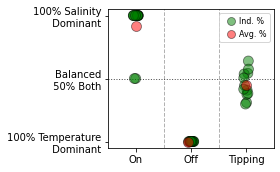

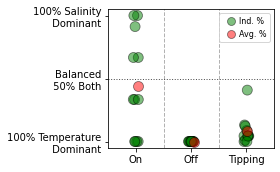

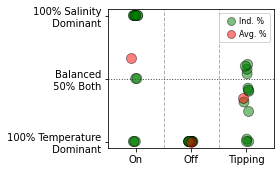

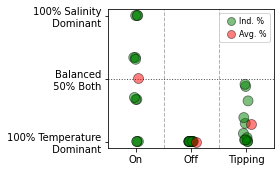

In [107]:
for mt in ['mlp', 'lstm']:
    for ft in ['s', 'ns']:
        fig = plot_salinity_dominance_swarm(ft, mt)
        fig.savefig(f'figures/lrp/lrp_swarm_{mt}_{ft}.pdf')

0

In [272]:
lrp = np.load('lrp_norm/lrp_mlp_s.npy')
#lrp.shape

In [273]:
lrp.shape

(12, 100000, 4)

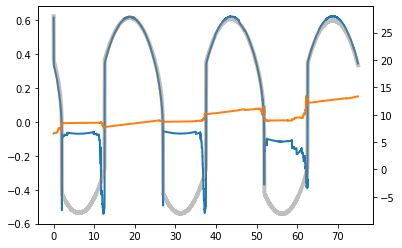

In [274]:
fig, ax = plt.subplots()
lrp = lrp.mean(axis=0)
ax_amoc = ax.twinx()
ax_amoc.plot(input_data[:, 0], qplot[:]/Sv, color='grey', linewidth=4, alpha=0.5)
ax.plot(input_data[:, 0], lrp[:, 1], label='LRP($\Delta S$)', color='tab:blue', linewidth=2)
ax.plot(input_data[:, 0], lrp[:, 2], label='LRP($\Delta T$)', color='tab:orange', linewidth=2)
#ax.set_ylim(-1, 1)

In [301]:
shap_vals = np.load('shap_npy/shap_mlp_s.npy').squeeze()

In [302]:
min_x, max_x = time_vals.min(), time_vals.max()
spacing = (max_x - min_x) / 100
valid_x, median_sal, median_temp = [], [], []
for i in range(100):
    start_x = min_x + i * spacing
    end_x = start_x + spacing
    subset = np.where((time_vals >= start_x) & (time_vals < end_x))[0]
    if len(subset) == 0:
        continue
    valid_x.append((start_x + end_x) / 2)
    median_sal.append(np.median(shap_sal_mean[subset]))
    median_temp.append(np.median(shap_temp_mean[subset]))

(12, 1, 1000, 4)

In [316]:
np.max(np.concatanat[1, 2, 3], [1, 2])

TypeError: 'list' object cannot be interpreted as an integer

In [319]:
shap_vals = np.load('shap_npy/shap_lstm_ns.npy')

In [320]:
shap_vals.shape

(12, 1, 1000, 128)

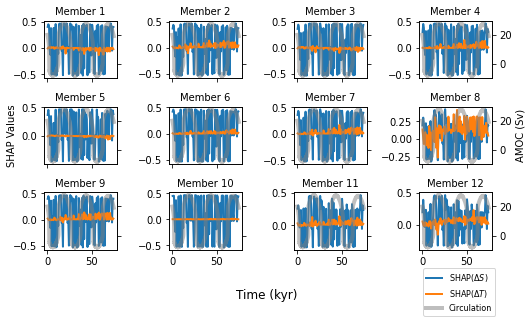

In [339]:
shap_vals = np.load('shap_npy/shap_mlp_s.npy').squeeze()
#shap_vals = shap_vals.reshape(12, 1000, 16, 4)  # Reshape to (ensemble, samples, timesteps, features)
#shap_vals = shap_vals[:, :, -1, :]  # Extract last timestep: (12, 1000, 4)
_, _, _, sample_indices = get_ensemble_shap_vals("s", "transformer")  # ← Change to "lstm"
input_data, output_data, qplot = get_data('s')  # ← Change to 'ns'
fig, ax = plt.subplots(3, 4, figsize=(7.5, 5))
ax = ax.flatten()
for i in range(12):
    shap_sal = shap_vals[i, :, 1]
    shap_temp = shap_vals[i, :, 2]
    time_vals = input_data[sample_indices, 0]
    min_x, max_x = time_vals.min(), time_vals.max()
    spacing = (max_x - min_x) / 100
    valid_x, median_sal, median_temp = [], [], []
    for j in range(100):
        start_x = min_x + j * spacing
        end_x = start_x + spacing
        subset = np.where((time_vals >= start_x) & (time_vals < end_x))[0]
        if len(subset) > 0:
            valid_x.append((start_x + end_x) / 2)
            median_sal.append(np.median(shap_sal[subset]))
            median_temp.append(np.median(shap_temp[subset]))
        
    ax_amoc = ax[i].twinx()
    ax_amoc.plot(input_data[64:, 0], qplot[64:]/Sv, color='grey', linewidth=4, alpha=0.5, label='Circulation')
    ax[i].plot(valid_x, median_sal, label='SHAP($\Delta S$)', color='tab:blue', linewidth=2)
    ax[i].plot(valid_x, median_temp, label='SHAP($\Delta T$)', color='tab:orange', linewidth=2)
    
#     shap_min = np.min([np.min(median_sal), np.min(median_temp)])
#     shap_max = np.max([np.max(median_sal), np.max(median_temp)])
#     shap_min_round = np.round(shap_min, 1)
#     shap_max_round = np.round(shap_max, 1)
#     ax[i].set_yticks([shap_min, shap_max])
#     ax[i].set_yticklabels([f'{shap_min_round:.1f}', f'{shap_max_round:.1f}'], fontsize=8)
    
    if i%4 != 3:
        ax_amoc.set_yticklabels([])
    if i < 8:
        ax[i].set_xticklabels([])
    ax[i].set_title('Member ' + str(i+1), fontsize=10)
    if i == 7:
        ax_amoc.set_ylabel('AMOC (Sv)')
    if i == 11:
        lines1, labels1 = ax[i].get_legend_handles_labels()
        lines2, labels2 = ax_amoc.get_legend_handles_labels()
        ax[i].legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8, bbox_to_anchor=(1.1, -0.25))
fig.supxlabel('Time (kyr)', y=0.15)
ax[4].set_ylabel('SHAP Values')
plt.tight_layout()

In [338]:
fig.savefig('figures/shap/ens_mlp_s.pdf', bbox_inches='tight')

In [168]:
preds = np.load('preds/mlp_s.npy')

In [169]:
input_data, output_data, qplot = get_data('s')

In [171]:
mlp_s_acc = []
for i in range(12):
    labels = (preds[i] > 0.5).astype(int)
    false_idx = len(np.where(labels != output_data)[0])
    acc_i = 1-false_idx/(100000-60032)
    mlp_s_acc.append(acc_i)

In [172]:
mlp_s_acc

[0.9972978382706165,
 0.9738290632506005,
 0.9967473979183347,
 0.9838871096877502,
 0.9964721777421938,
 0.9974729783827062,
 0.9972978382706165,
 0.9976731385108086,
 0.997623098478783,
 0.9784327461969575,
 0.9987740192153723,
 0.9977732185748599]

In [145]:
lstm_s_acc

[0.9635458366693355,
 0.9910678542834267,
 0.9794585668534828,
 0.9996997598078463,
 0.9898168534827863,
 0.9962720176140912,
 0.9528622898318655,
 0.994845876701361,
 0.9830864691753403,
 0.9204113290632506,
 0.9988490792634107,
 0.9986989591673339]

In [139]:
mlp_s_acc

[0.998949159327462,
 0.9756805444355484,
 0.9986989591673339,
 0.9857385908726981,
 0.9983987189751802,
 0.9992243795036029,
 0.9991993594875901,
 0.9993494795836669,
 0.9993744995996797,
 0.9803843074459567,
 0.9998498799039232,
 0.9992493995196157]

In [124]:
flase_idx0

array([False, False, False, ..., False, False, False])

On: 70274, Off: 28743, Tipping: 983


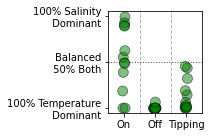

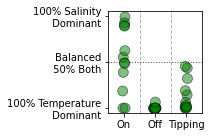

In [145]:
plot_salinity_dominance_swarm('ns', 'lstm')

On: 56733, Off: 42090, Tipping: 1177


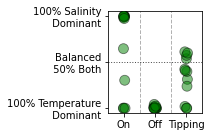

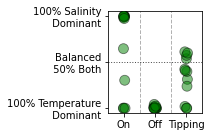

In [146]:
plot_salinity_dominance_swarm('s', 'lstm')

In [58]:
lrp = np.load('lrp_npy/lrp_mlp_s.npy')

In [59]:
lrp.shape

(12, 100000, 4)

In [70]:
def plot_lrp_dominance_members(forcing_type, model_type, xaxis):
    """
    Generate a figure with 12 subplots of dominating layer-wise relevance values.
    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).
    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing 
    """
    offset = 0
    if model_type == 'lstm':
        if forcing_type == 'ns':
            offset = 31
        else:
            offset = 15
    
    lrp_vals = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    lrp_feature1 = lrp_vals[:, :, 1]  # salinity (feature 1)
    lrp_feature2 = lrp_vals[:, :, 2]  # temperature (feature 2)
    combined_min = min(lrp_feature1.min(), lrp_feature2.min())
    combined_max = max(lrp_feature1.max(), lrp_feature2.max())
    lrp_feature1_norm = (lrp_feature1 - combined_min) / (combined_max - combined_min)
    lrp_feature2_norm = (lrp_feature2 - combined_min) / (combined_max - combined_min)
    # Stack them back into the original shape
    lrp_vals = np.stack([lrp_vals[:, :, 0], lrp_feature1_norm, lrp_feature2_norm], axis=2)
    
    input_data, output_data, qplot = get_data(forcing_type)
    
    fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
    if xaxis == "t":
        fig.supxlabel('Time (kyr)')
    else:
        fig.supxlabel('Freshwater Forcing (m/yr)')
    fig.supylabel('AMOC (Sv)')
    fig.suptitle('Dominating LRP Values for Ensemble Members')
    ax = ax.flatten()
    for i in range(12):
        lrp_i = lrp_vals[i, :, :]
        lrp_temp = lrp_i[:, 2]
        lrp_sal = lrp_i[:, 1]
        colors = np.where(lrp_temp > lrp_sal, 1, 0)  # 1 for temp, 0 for salinity
        color_map = {1: '#ff7f0e', 0: '#1f77b4'}
        color_list = [color_map[c] for c in colors]
        
        if xaxis == "t":
            scatter = ax[i].scatter(input_data[offset:, 0], qplot[offset:]/Sv, 
                                c=color_list, marker='o', s=18)
            ax[i].plot(input_data[offset:, 0], qplot[offset:]/Sv, linestyle=':', color='grey')
        else: 
            scatter = ax[i].scatter(input_data[offset:, 3]/Fs_to_m_per_year, qplot[offset:]/Sv, 
                                c=color_list, marker='o', s=18)
            ax[i].plot(input_data[offset:, 3]/Fs_to_m_per_year, qplot[offset:]/Sv, linestyle=':', color='grey')
        
        ax[i].axhline(0, color='black', linestyle='--')
        ax[i].set_title('Ensemble Member ' + str(i+1))
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['LRP ($\Delta T$)', 'LRP ($\Delta S$)'], 
               loc='lower right')
    return fig

In [74]:
lrp.shape

(12, 100000, 4)

In [261]:
def plot_lrp_members(model_type, forcing_type):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(14, 10))
    axes = axes.flatten()
    
    # Load data
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    
    if model_type == 'lstm':
        lrp = lrp[:, :, -1, :]
    else:
        lrp = lrp[:, :, :]
    
    # Determine shift based on model and forcing type
    if model_type == "lstm":
        shift = 15 if forcing_type == "s" else 31
    else:
        shift = 0
    
    total_crop = 64
    crop_after_shift = max(0, total_crop - shift)
    
    # Collect legend handles manually
    legend_handles = []
    legend_labels = []
    
    for member_idx in range(12):
        ax = axes[member_idx]
        
        # Get LRP for this ensemble member
        lrp_member = lrp[member_idx]  # Shape: (100000, 4)
        lrp_member_crop = lrp_member[crop_after_shift:]
        
        # Normalize each member to [0, 1]
        lrp_min = lrp_member_crop.min()
        lrp_max = lrp_member_crop.max()
        lrp_member_norm = (lrp_member_crop - lrp_min) / (lrp_max - lrp_min)
        
        lrp_sal = lrp_member_norm[:, 1]
        lrp_temp = lrp_member_norm[:, 2]
        
        aligned_input = input_data[shift:][crop_after_shift:]
        aligned_qplot = qplot[shift:][crop_after_shift:]
        
        # --- Plot LRP curves ---
        line_sal, = ax.plot(
            aligned_input[:, 0], lrp_sal,
            color="tab:blue", linewidth=2, label="LRP($\Delta S$)"
        )
        line_temp, = ax.plot(
            aligned_input[:, 0], lrp_temp,
            color="tab:orange", linewidth=2, label="LRP($\Delta T$)"
        )
        
        ax.set_title(f"Ensemble Member {member_idx + 1}")
        #ax.set_ylim([0, 1])
        
        if member_idx % 3 == 0:  # Left column
            ax.set_ylabel("LRP values (normalized)")
        if member_idx >= 9:  # Bottom row
            ax.set_xlabel("Time (kyr)")
        
        # --- Plot AMOC (circulation) on twin axis ---
        ax_r = ax.twinx()
        line_circ, = ax_r.plot(
            aligned_input[:, 0],
            aligned_qplot / Sv,
            linewidth=4,
            color="grey",
            alpha=0.3,
            label="Circulation"
        )
        
        if member_idx % 3 == 2:  # Right column
            ax_r.set_ylabel("AMOC (Sv)", labelpad=8)
        else:
            ax_r.set_yticklabels([])
        
        # Store handles for legend (only once)
        if member_idx == 0:
            legend_handles = [line_sal, line_temp, line_circ]
            legend_labels = [h.get_label() for h in legend_handles]
    
    # --- Combined legend ---
    fig.legend(
        legend_handles,
        legend_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        frameon=False
    )
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    return fig

In [ ]:
fig = plot_lrp_members()

In [93]:
lrp = np.load(f'lrp_npy/lrp_mlp_s.npy')

In [94]:
lrp.shape

(12, 100000, 4)

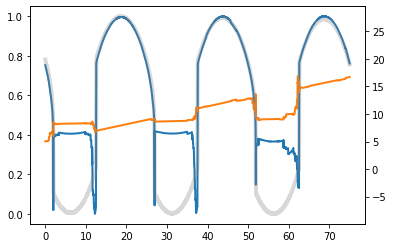

In [97]:
forcing_type="s"
model_type = 'mlp'
input_data, output_data, qplot = get_data(forcing_type)
lrp = np.load(f'lrp_npy/lrp_mlp_s.npy')
    
# Determine shift based on model and forcing type
if model_type == "lstm":
    shift = 15 if forcing_type == "s" else 31
else:
    shift = 0

total_crop = 64
crop_after_shift = max(0, total_crop - shift)


# Get LRP for this ensemble member
lrp_member = lrp.mean(axis=0)  # Shape: (100000, 4)
lrp_member_crop = lrp_member[crop_after_shift:]

# Normalize each member to [0, 1]
lrp_min = lrp_member_crop.min()
lrp_max = lrp_member_crop.max()
lrp_member_norm = (lrp_member_crop - lrp_min) / (lrp_max - lrp_min)

lrp_sal = lrp_member_norm[:, 1]
lrp_temp = lrp_member_norm[:, 2]

aligned_input = input_data[shift:][crop_after_shift:]
aligned_qplot = qplot[shift:][crop_after_shift:]

fig, ax = plt.subplots()
        
# --- Plot LRP curves ---
line_sal, = ax.plot(
    aligned_input[:, 0], lrp_sal,
    color="tab:blue", linewidth=2, label="LRP($\Delta S$)"
)
line_temp, = ax.plot(
    aligned_input[:, 0], lrp_temp,
    color="tab:orange", linewidth=2, label="LRP($\Delta T$)"
)

#ax.set_title(f"Ensemble Member {member_idx + 1}")
#ax.set_ylim([0, 1])


# --- Plot AMOC (circulation) on twin axis ---
ax_r = ax.twinx()
line_circ, = ax_r.plot(
    aligned_input[:, 0],
    aligned_qplot / Sv,
    linewidth=4,
    color="grey",
    alpha=0.3,
    label="Circulation"
)

In [131]:
lrp = np.load("lrp_npy/lrp_mlp_s.npy")
lrp_ts = lrp[:, :, 1:3]

In [132]:
lrp_norm = lrp[:, :, -1, :] / (np.max(np.abs(lrp[:, :, -1, :]), axis=2, keepdims=True) + 1e-8)

In [134]:
lrp_norm.shape

(12, 99985, 4)

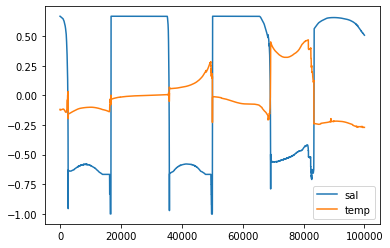

In [133]:
plt.plot(lrp_norm.mean(axis=0)[:, 1], label='sal')
plt.plot(lrp_norm.mean(axis=0)[:, 2], label='temp')
plt.legend()

In [117]:
lrp_norm.mean(axis=0).shape

(100000, 4)

In [109]:
max_lrp = lrp_ts.max(axis=2)

In [132]:
def plot_lrp_members(model_type, forcing_type):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=True)
    axes = axes.flatten()
    
    # Load data
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    
    # Determine shift based on model and forcing type
    if model_type == "lstm":
        shift = 15 if forcing_type == "s" else 31
    else:
        shift = 0
    
    total_crop = 64
    crop_after_shift = max(0, total_crop - shift)
    
    # Normalize by max absolute value across features (axis 2)
    #lrp_norm = lrp / np.max(np.abs(lrp), axis=2, keepdims=True)
    # Normalize by max absolute value across features (axis 2)
    lrp_norm = lrp / (np.max(np.abs(lrp), axis=2, keepdims=True) + 1e-8)
    
    # Collect legend handles manually
    legend_handles = []
    legend_labels = []
    
    for member_idx in range(12):
        ax = axes[member_idx]
        
        # Get normalized LRP for this ensemble member
        lrp_member = lrp_norm[member_idx, crop_after_shift:]
        lrp_sal = lrp_member[:, 1]
        lrp_temp = lrp_member[:, 2]
        
        aligned_input = input_data[shift:][crop_after_shift:]
        aligned_qplot = qplot[shift:][crop_after_shift:]
        
        # --- Plot LRP curves ---
        line_sal, = ax.plot(
            aligned_input[:, 0], lrp_sal,
            color="tab:blue", linewidth=2, label="LRP($\Delta S$)"
        )
        line_temp, = ax.plot(
            aligned_input[:, 0], lrp_temp,
            color="tab:orange", linewidth=2, label="LRP($\Delta T$)"
        )
        
        ax.set_title(f"Ensemble Member {member_idx + 1}")
        
        if member_idx % 3 == 0:  # Left column
            ax.set_ylabel("LRP values (normalized)")
        if member_idx >= 9:  # Bottom row
            ax.set_xlabel("Time (kyr)")
        
        # --- Plot AMOC (circulation) on twin axis ---
        ax_r = ax.twinx()
        line_circ, = ax_r.plot(
            aligned_input[:, 0],
            aligned_qplot / Sv,
            linewidth=4,
            color="grey",
            alpha=0.3,
            label="Circulation"
        )
        
        if member_idx % 3 == 2:  # Right column
            ax_r.set_ylabel("AMOC (Sv)", labelpad=8)
        else:
            ax_r.set_yticklabels([])
        
        # Store handles for legend (only once)
        if member_idx == 0:
            legend_handles = [line_sal, line_temp, line_circ]
            legend_labels = [h.get_label() for h in legend_handles]
    
    # --- Combined legend ---
    fig.legend(
        legend_handles,
        legend_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        frameon=False
    )
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    return fig

In [292]:
input_data, output_data, qplot = get_data('s')
stable_on = np.where(qplot/Sv > 20)
stable_off = np.where(qplot/Sv < -5)
stable_points_s = np.hstack([stable_on[0], stable_off[0]])

In [442]:
input_data, output_data, qplot = get_data('ns')
stable_on = np.where(qplot/Sv > 27)
stable_off = np.where(qplot/Sv < -8)
stable_points_ns = np.hstack([stable_on[0], stable_off[0]])

In [534]:
tp1 = np.where((input_data[:, 0] > 7) & (input_data[:, 0] < 9))[0]
tp2 = np.where((input_data[:, 0] > 30.5) & (input_data[:, 0] < 32.5))[0]
tp3 = np.where((input_data[:, 0] > 43) & (input_data[:, 0] < 45))[0]
tp4 = np.where((input_data[:, 0] > 55) & (input_data[:, 0] < 57))[0]
tp5 = np.where((input_data[:, 0] > 68) & (input_data[:, 0] < 70))[0]
stable_pts = np.hstack([tp1, tp2, tp3, tp4, tp5])

In [538]:
len(stable_pts)

13332

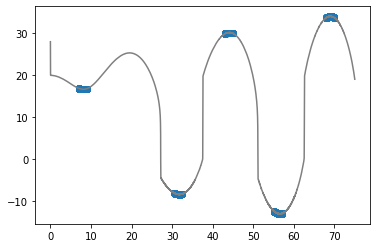

In [537]:
plt.scatter(input_data[stable_pts, 0], qplot[stable_pts]/Sv)
# plt.scatter(input_data[tp2, 0], qplot[tp2]/Sv)
# plt.scatter(input_data[tp3, 0], qplot[tp3]/Sv)
# plt.scatter(input_data[tp4, 0], qplot[tp4]/Sv)
# plt.scatter(input_data[tp5, 0], qplot[tp5]/Sv)
plt.plot(input_data[:, 0], qplot/Sv, color='grey')

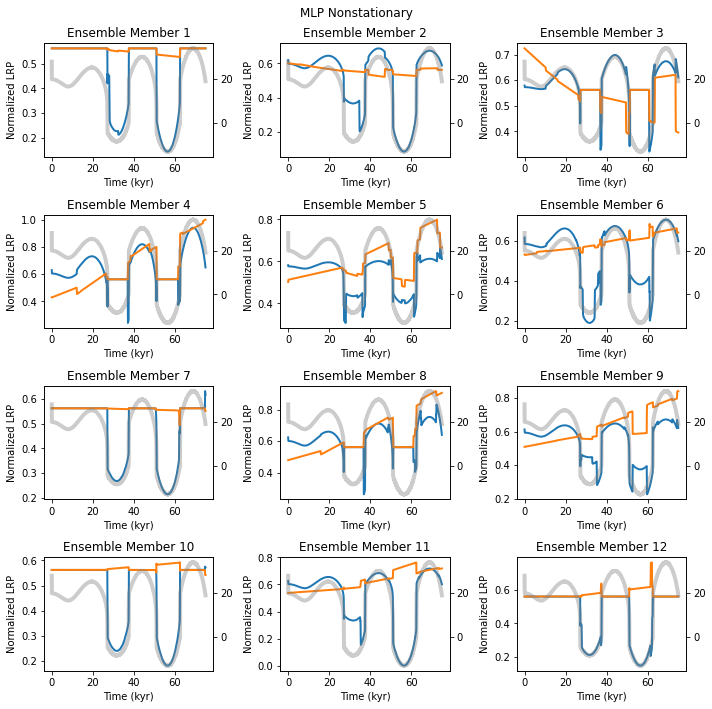

In [364]:
from scipy.signal import savgol_filter

fig, ax = plt.subplots(4, 3, figsize=(10, 10))
ax = ax.flatten()

for i in range(12):
    
    # window_length must be odd, polyorder is degree of polynomial
    sal_smooth = savgol_filter(lrp_norm[i, :, 1], window_length=101, polyorder=1)
    temp_smooth = savgol_filter(lrp_norm[i, :, 2], window_length=101, polyorder=1)

    time_vals = input_data[:, 0]
    ax[i].plot(time_vals, sal_smooth, linewidth=2, label='Salinity', color='tab:blue')
    ax[i].plot(time_vals, temp_smooth, linewidth=2, label='Temperature', color='tab:orange')

    ax[i].set_xlabel('Time (kyr)')
    ax[i].set_ylabel('Normalized LRP')
    ax[i].set_title(f'Ensemble Member {i+1}')
    
    ax_t = ax[i].twinx()
    ax_t.plot(time_vals, qplot/Sv, color='grey', alpha=0.4, lw=4)
    #ax[i].legend(fontsize=11)
    #ax.grid(True, alpha=0.3)
    #ax.set_ylim([0, 1])
    
fig.suptitle('MLP Nonstationary')
fig.tight_layout()
fig.savefig('mlp_ns_lrp_members.pdf')